In [ ]:
# !pip install Ipython

# Load

In [1]:
# ref: https://blog.csdn.net/woshicver/article/details/124701431

import os
import sys
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

from PIL import Image
import cv2
import mediapipe as mp
from mediapipe.python.solutions import pose as mp_pose
import torch

In [ ]:
sys.path

In [ ]:
profile_img = r'C:\Users\EricWang\Pictures\sakuragi.jpg'

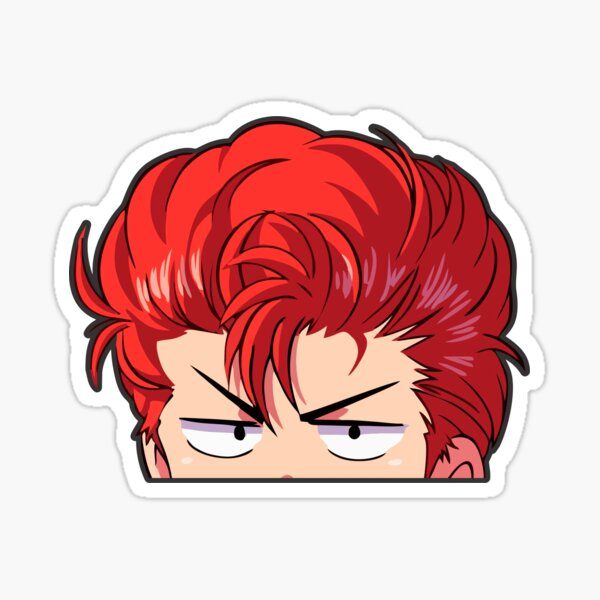

In [3]:
# method 1: PIL.Image.open()
Image.open(profile_img)

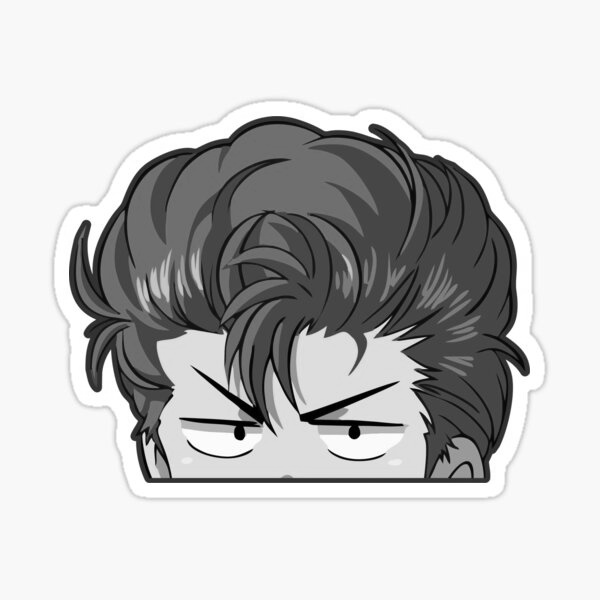

In [14]:
# convert to gray
image = cv2.imread(profile_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('output\sakuragi.jpg', image) # save
Image.open('output\sakuragi.jpg')

In [91]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(cv2.imread(profile_img))
axs[1].imshow(image)

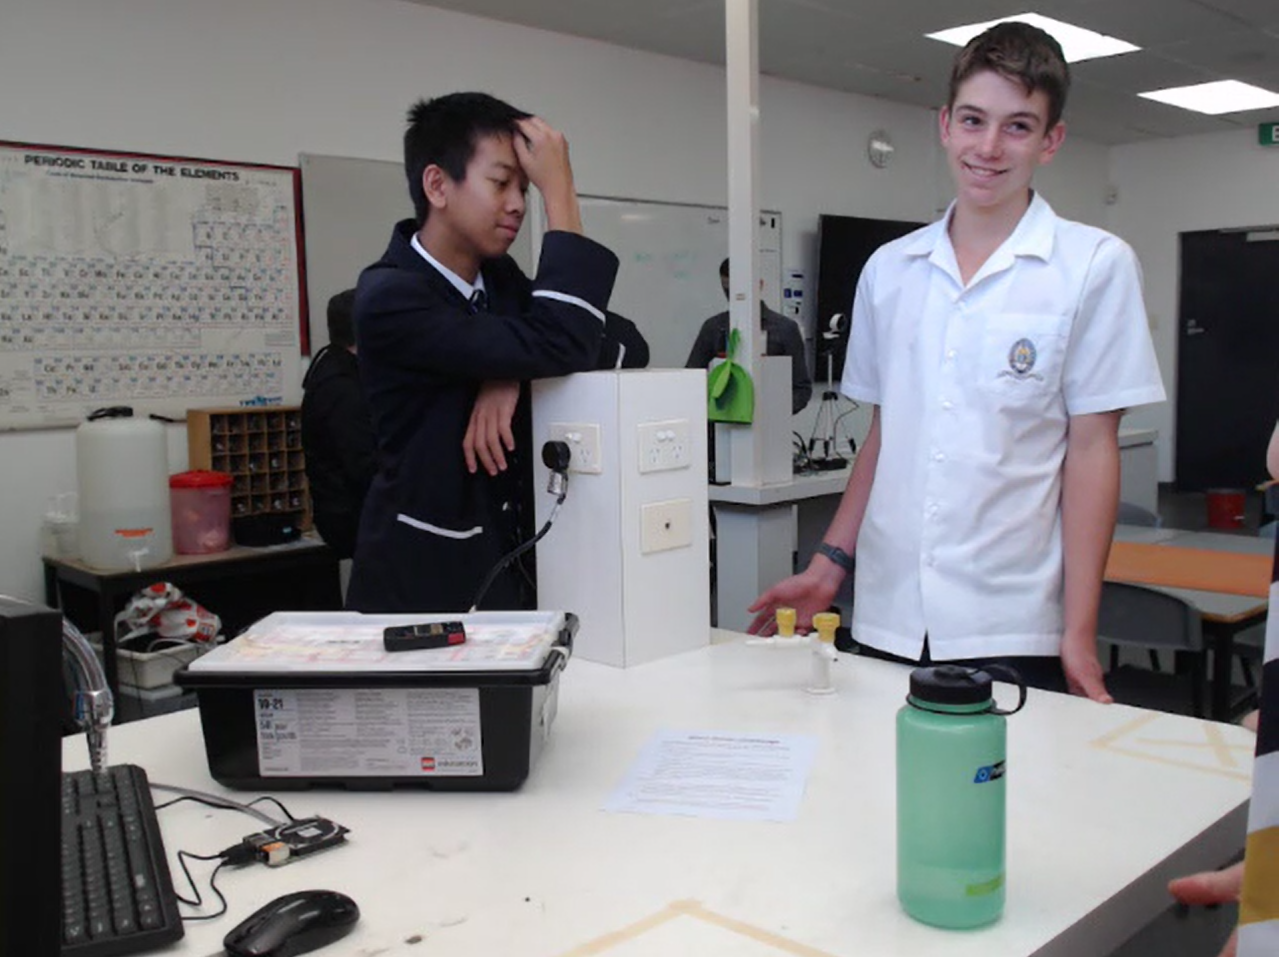

In [6]:
# method 2: IPython.display.Image()
display.Image(image_file)

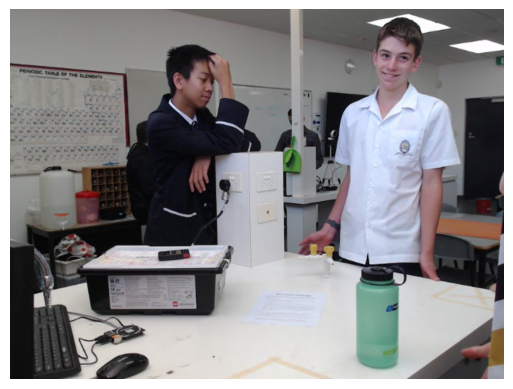

In [4]:
# method 3: cv2.imread() + plt.imshow()
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(dpi=100)
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
# method 4: cv2.imshow() in while loop
image = cv2.imread(image_file)
while True:
    cv2.imshow('Image', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [17]:
def findposition(results, img, draw=True):
    lmList = []
    # if results are available
    if results.pose_landmarks:
        for lm_id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c = img.shape
            # print(lm_id, lm)
            # lm contains id, x,y,z, visibility score.
            # x,y,z are ratios, to get the pixel values from landmark values,
            # need to multiply landmark ratios (x or y) with image shape (w or h)
            cx, cy = int(lm.x * w), int(lm.y * h)
            # can choose what fields to be stored. Here just include all 5 available fields
            lmList.append([lm_id, cx, cy, round(lm.z, 5), round(lm.visibility, 7)])
            if draw:
                # overlay on existing dots
                cv2.circle(img, (cx, cy), 5, (255, 0, 0), cv2.FILLED)

    return lmList

def findAngle(lmList, img, p1, p2, p3, draw=True):
    # get landmarks
    x1, y1 = lmList[p1][1:3]
    x2, y2 = lmList[p2][1:3]
    x3, y3 = lmList[p3][1:3]

    # calculate angle (convert radians to degrees)
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    if angle < 0:  # if negative angle value, convert to positive
        angle += 360
    if angle > 180:
        angle = 360 - angle

    # print('Angle:', angle)

    # draw
    if draw:
        cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)  # white line
        cv2.line(img, (x3, y3), (x2, y2), (255, 255, 255), 2)  # white line
        cv2.circle(img, (x1, y1), 8, (0, 0, 255), cv2.FILLED)
        cv2.circle(img, (x1, y1), 12, (0, 0, 255), 1)
        cv2.circle(img, (x2, y2), 8, (0, 0, 255), cv2.FILLED)
        cv2.circle(img, (x2, y2), 12, (0, 0, 255), 1)
        cv2.circle(img, (x3, y3), 8, (0, 0, 255), cv2.FILLED)
        cv2.circle(img, (x3, y3), 12, (0, 0, 255), 1)
        cv2.putText(img, str(int(angle)), (x2 - 35, y2 + 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

    return angle

#  YOLO model

## `YOLOv5s`

YOLOv5 small\
14MB

In [6]:
# Model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\EricWang/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-4-1 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Quadro P520, 2048MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [17]:
# yolo_model = torch.load('yolov5s.pt')
# yolo_model.eval()

In [18]:
# PATH = r'C:\Users\EricWang/.cache\torch\hub\ultralytics_yolov5_master\models'
# yolo_model = torch.load_state_dict(torch.load(PATH))

In [19]:
# yolo_model = torch.hub.load(r'C:\Users\EricWang/.cache\torch\hub\ultralytics_yolov5_master\models', 'yolov5s')

In [20]:
yolo_model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [21]:
print(yolo_model.classes)

None


In [22]:
# YOLO classes
yolo_model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## Config model

In [7]:
# config the model
# set model class
yolo_model.classes = [0] # only detect person

# set confidence level
yolo_model.conf = 0.7 # return objects > 0.7

# set 

# Detect 1 image

In [559]:
image_file = r'C:\Users\EricWang\Pictures\sample_image.png'
issue_image = r'C:\Users\EricWang\Pictures\issue_image_4.png'

In [560]:
image = cv2.imread(issue_image)
while True:
    cv2.imshow('result', image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [561]:
result = yolo_model(image)
# clear_output()

result

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 813x1089 4 persons
Speed: 11.5ms pre-process, 38.9ms inference, 3.0ms NMS per image at shape (1, 3, 480, 640)

In [562]:
result.render()

[array([[[127, 128, 130],
         [127, 129, 130],
         [127, 128, 130],
         ...,
         [171, 136, 139],
         [141, 104, 109],
         [110,  73,  79]],
 
        [[128, 129, 131],
         [128, 129, 131],
         [127, 129, 131],
         ...,
         [186, 149, 152],
         [157, 119, 123],
         [118,  79,  84]],
 
        [[128, 130, 131],
         [128, 130, 131],
         [128, 130, 131],
         ...,
         [200, 163, 164],
         [178, 139, 141],
         [136,  96,  99]],
 
        ...,
 
        [[ 11,  13,  13],
         [ 11,  14,  13],
         [ 11,  13,  13],
         ...,
         [ 28,  24,  23],
         [ 28,  24,  22],
         [ 28,  24,  23]],
 
        [[ 11,  13,  13],
         [ 11,  13,  13],
         [ 11,  13,  13],
         ...,
         [ 27,  24,  22],
         [ 27,  24,  22],
         [ 28,  24,  23]],
 
        [[ 11,  13,  13],
         [ 11,  13,  13],
         [ 11,  13,  13],
         ...,
         [ 28,  24,  23],
  

In [563]:
while True:
    cv2.imshow('result', np.transpose(result.ims[0], (0,1,2)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

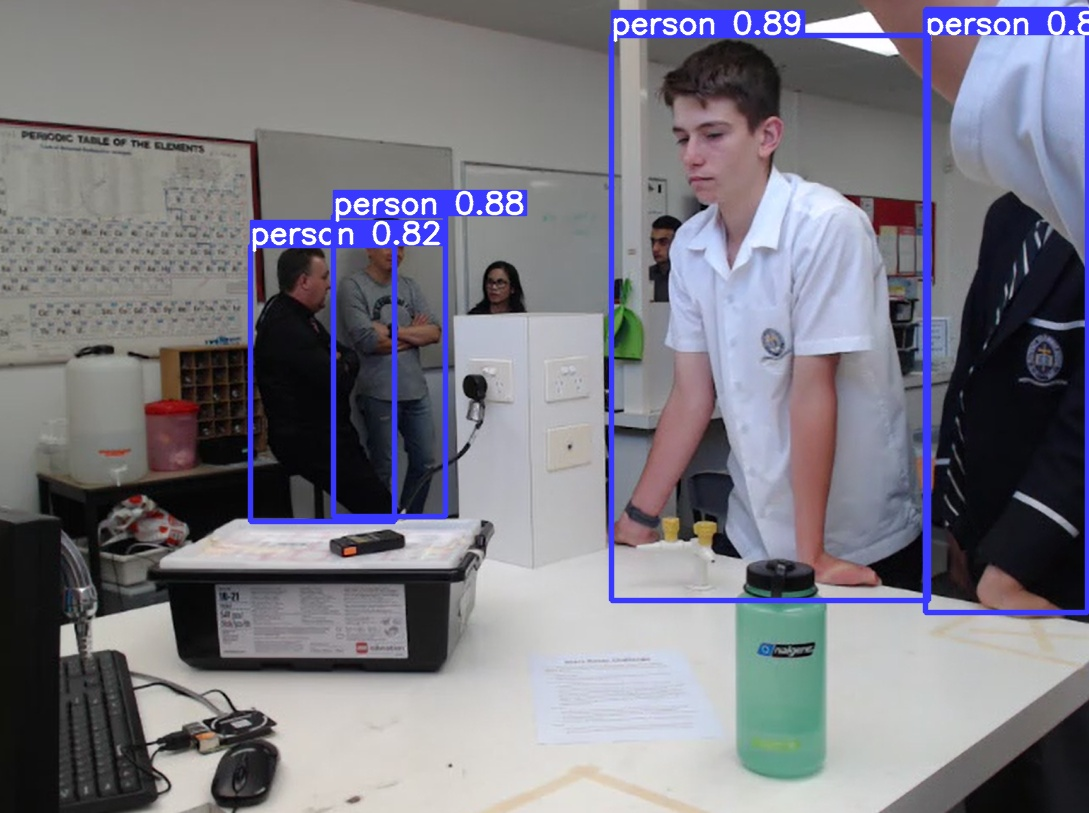

In [564]:
cv2.imwrite('output/tmp_img.jpg', np.transpose(result.ims[0], (0,1,2)))
Image.open('output/tmp_img.jpg')

In [30]:
result.save()

Saved 1 image to runs\detect\exp5


In [420]:
len(result.pred[0]), len(result.xyxy[0])

(4, 4)

## get result image size

`result_height`\
`result_width`

In [565]:
# get result image size
result_height = result.ims[0].shape[0]
result_width = result.ims[0].shape[1]
print('INFO: result image height: {}\nINFO: result image width: {}'.format(result_height, result_width))

INFO: result image height: 813
INFO: result image width: 1089


## get result dataframe

`df_result_person`

In [567]:
# centroid, width, height
df_result_xywh = result.pandas().xywh[0]
df_result_xywh

xcenter     ycenter       width      height  confidence  class    name
0   770.222900  318.189392  316.896545  564.721436    0.888233      0  person
1   389.283936  365.771301  112.454346  300.539520    0.881914      0  person
2   322.670135  383.439026  144.475754  275.946075    0.817142      0  person
3  1006.913635  311.191376  162.090698  602.997131    0.804139      0  person

In [568]:
(888.425+952.9)/2

920.6624999999999

In [570]:
# bounding boxes coordinates
df_result_xyxy = result.pandas().xyxy[0]
df_result_xyxy

xmin        ymin         xmax        ymax  confidence  class    name
0  611.774597   35.828697   928.671143  600.550110    0.888233      0  person
1  333.056763  215.501556   445.511108  516.041077    0.881914      0  person
2  250.432266  245.465973   394.908020  521.412048    0.817142      0  person
3  925.868286    9.692826  1087.958984  612.689941    0.804139      0  person

**NOTE**:\
**Y values start from top of image. Small Y values mean close to the top of image.**

For example, `ymin=20.969` means it's almost reached the top of the image.

In [571]:
# merge xywh and xyxy: detection results of 'person', i.e., 'name'=='person' (or 'class'==0)
df_result_person = result.pandas().xyxy[0]
df_result_person[['xcenter','ycenter','width','height']] = df_result_xywh[['xcenter','ycenter','width','height']]
# df_result_person['xcenter'] = df_result_xywh['xcenter']
# df_result_person['ycenter'] = df_result_xywh['ycenter']
# df_result_person['width'] = df_result_xywh['width']
# df_result_person['height'] = df_result_xywh['height']

In [572]:
df_result_person

xmin        ymin         xmax        ymax  confidence  ...    name  \
0  611.774597   35.828697   928.671143  600.550110    0.888233  ...  person   
1  333.056763  215.501556   445.511108  516.041077    0.881914  ...  person   
2  250.432266  245.465973   394.908020  521.412048    0.817142  ...  person   
3  925.868286    9.692826  1087.958984  612.689941    0.804139  ...  person   

       xcenter     ycenter       width      height  
0   770.222900  318.189392  316.896545  564.721436  
1   389.283936  365.771301  112.454346  300.539520  
2   322.670135  383.439026  144.475754  275.946075  
3  1006.913635  311.191376  162.090698  602.997131  

[4 rows x 11 columns]

## filter out background person

by
- detected person area < 45000

In [573]:
df_result_person['width'] * df_result_person['height']

0    178958.272044
1     33796.975109
2     39867.517253
3     97740.226058
dtype: float64

In [574]:
# mark 'background' according to person bounding box area
area_threshold = 43000
df_result_person['filter'] = 'front'
df_result_person.loc[(df_result_person['width'] * df_result_person['height'] < area_threshold) & 
                     (df_result_person['xmax'] < 550) &
                     (df_result_person['ymin'] > 210)
                     , 'filter'] = 'background'
df_result_person

xmin        ymin         xmax        ymax  confidence  ...  \
0  611.774597   35.828697   928.671143  600.550110    0.888233  ...   
1  333.056763  215.501556   445.511108  516.041077    0.881914  ...   
2  250.432266  245.465973   394.908020  521.412048    0.817142  ...   
3  925.868286    9.692826  1087.958984  612.689941    0.804139  ...   

       xcenter     ycenter       width      height      filter  
0   770.222900  318.189392  316.896545  564.721436       front  
1   389.283936  365.771301  112.454346  300.539520  background  
2   322.670135  383.439026  144.475754  275.946075  background  
3  1006.913635  311.191376  162.090698  602.997131       front  

[4 rows x 12 columns]

In [575]:
# df_result_person.info()
df_result_person[(df_result_person['name']=='person') & (df_result_person['filter']=='front')]

xmin       ymin         xmax        ymax  confidence  ...  \
0  611.774597  35.828697   928.671143  600.550110    0.888233  ...   
3  925.868286   9.692826  1087.958984  612.689941    0.804139  ...   

       xcenter     ycenter       width      height  filter  
0   770.222900  318.189392  316.896545  564.721436   front  
3  1006.913635  311.191376  162.090698  602.997131   front  

[2 rows x 12 columns]

In [576]:
# filter 'person', sort by confidence
df_result_person = df_result_person[(df_result_person['name']=='person') &
                                    (df_result_person['filter']=='front')].sort_values('confidence', ascending=False)

# reset index
df_result_person.index = range(df_result_person.shape[0])

# current person result summary
df_result_person

xmin       ymin         xmax        ymax  confidence  ...  \
0  611.774597  35.828697   928.671143  600.550110    0.888233  ...   
1  925.868286   9.692826  1087.958984  612.689941    0.804139  ...   

       xcenter     ycenter       width      height  filter  
0   770.222900  318.189392  316.896545  564.721436   front  
1  1006.913635  311.191376  162.090698  602.997131   front  

[2 rows x 12 columns]

In [577]:
df_result_person['p'] = ['p' + str(i) for i in df_result_person.index.to_list()]
df_result_person

xmin       ymin         xmax        ymax  confidence  ...  \
0  611.774597  35.828697   928.671143  600.550110    0.888233  ...   
1  925.868286   9.692826  1087.958984  612.689941    0.804139  ...   

      ycenter       width      height  filter   p  
0  318.189392  316.896545  564.721436   front  p0  
1  311.191376  162.090698  602.997131   front  p1  

[2 rows x 13 columns]

# Number of person (N)

`N`

In [578]:
N = df_result_person.shape[0]
print('INFO: Number of detected person: {}'.format(N))

INFO: Number of detected person: 2


# Group Physical Density (GPD)

`GPD`

$$GPD = \frac{1}{Area\space of\space group\space bounding\space boxes}\\
= \frac{1}{(xmax_{rightest} - xmin_{leftest})*{\frac{1}{N}{\sum_{N}ymin}}}
$$

In [479]:
df_result_person['xmax'].max(), df_result_person['xmin'].min()

(1084.0262451171875, 633.672607421875)

In [480]:
# GPD = 1/Area = 1/(bb_width * bb_height)

# bb_width: Xmax of the most RHS person - Xmin of the most LHS person, i.e., largest Xmax - lowest Xmin
bb_width = df_result_person['xmax'].max() - df_result_person['xmin'].min()

## bb_height: for each person, image total height - Ymin of each person
avg_height = np.mean([result_height - df_result_person.loc[i,'ymin'] for i in range(N)])

# get Group Physical Density
GPD = 1*1e6/(bb_width * avg_height)

print('INFO: Person bounding boxes width: {}\nINFO: Person average height: {}'.format(bb_width, avg_height))
print('INFO: Group Physical Density (GPD): {}'.format(GPD))

INFO: Person bounding boxes width: 450.3536376953125
INFO: Person average height: 711.2679557800293
INFO: Group Physical Density (GPD): 3.121857545398051


# Social distance (SD)

`SD`

$$SD = Average\space Centroid\space Distance \\
=\frac{1}{N}\sum_{N}{xcenter_1 - xcenter_2}$$

In [481]:
df_ = df_result_person[['p','xcenter']].assign(key=1).merge(df_result_person[['p','xcenter']].assign(key=1), on='key', suffixes=('','_y'))
df_

p     xcenter  key p_y   xcenter_y
0  p0  750.416809    1  p0  750.416809
1  p0  750.416809    1  p1  988.865234
2  p1  988.865234    1  p0  750.416809
3  p1  988.865234    1  p1  988.865234

In [482]:
df_['distance'] = df_.apply(lambda x: x.xcenter - x.xcenter_y, axis=1)
df_

p     xcenter  key p_y   xcenter_y    distance
0  p0  750.416809    1  p0  750.416809    0.000000
1  p0  750.416809    1  p1  988.865234 -238.448425
2  p1  988.865234    1  p0  750.416809  238.448425
3  p1  988.865234    1  p1  988.865234    0.000000

In [483]:
df_.set_index(df_result_person[['xcenter']].columns.to_list()+['p_y'])['distance'].unstack()

p_y                 p0          p1
xcenter                           
750.416809    0.000000 -238.448425
988.865234  238.448425    0.000000

In [484]:
df_.set_index(df_result_person[['xcenter']].columns.to_list()+['p_y'])['distance'].unstack().add_prefix('dist_').reset_index()
df_

p     xcenter  key p_y   xcenter_y    distance
0  p0  750.416809    1  p0  750.416809    0.000000
1  p0  750.416809    1  p1  988.865234 -238.448425
2  p1  988.865234    1  p0  750.416809  238.448425
3  p1  988.865234    1  p1  988.865234    0.000000

In [485]:
df_ = (df_.set_index(df_result_person[['p','xcenter']].columns.to_list()+['p_y'])['distance']
      .unstack()
      .add_prefix('dist_')
      .reset_index())
df_

p_y   p     xcenter     dist_p0     dist_p1
0    p0  750.416809    0.000000 -238.448425
1    p1  988.865234  238.448425    0.000000

In [486]:
df_result_person = df_result_person.merge(df_)
df_result_person

xmin        ymin         xmax        ymax  confidence  ...  \
0  633.672607  197.376251   867.161011  591.293335    0.651092  ...   
1  893.704224    8.087837  1084.026245  798.688599    0.575778  ...   

       height filter   p     dist_p0     dist_p1  
0  393.917084  front  p0    0.000000 -238.448425  
1  790.600769  front  p1  238.448425    0.000000  

[2 rows x 15 columns]

In [487]:
SD_sum = df_.iloc[:,-N:].abs().sum().sum()/2
SD_sum

238.44842529296875

In [488]:
SD_avg = SD_sum/N
SD_avg

119.22421264648438

In [491]:
SD_avg = df_.iloc[:,-N:].abs().mean()
print('INFO: total SD: {}\nINFO: average SD: {}'.format(SD_sum, SD_avg))

INFO: total SD: 238.44842529296875
INFO: average SD: p_y
dist_p0    119.224213
dist_p1    119.224213
dtype: float64


# display detected objects

In [493]:
result.ims[0].shape

(814, 1087, 3)

In [494]:
# display object-detected image
result.render()
while True:
    # resize result image according to scale_percent
    scale_percent = 40 # %
    width_ = int(result_width * scale_percent / 100)
    height_ = int(result_height * scale_percent / 100)
    dim = (width_, height_)
#     print(dim)
    
    resized = cv2.resize(result.ims[0], dim, interpolation=cv2.INTER_AREA)
#     cv2.imshow('result', result.ims[0])
    cv2.imshow('Resized image', resized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [495]:
cv2.imwrite('output\sample_image_detected_resized.jpg', resized)

True

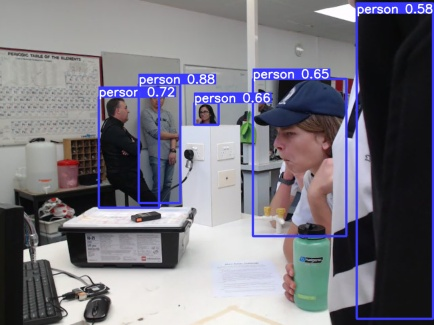

In [496]:
Image.open('output\sample_image_detected_resized.jpg')

In [137]:
# plt.imshow(result.ims[0])
# plt.show()

# timestamp format

In [ ]:
from datetime import datetime, timedelta, tzinfo

In [192]:
current_time = datetime.now()
current_time_str = current_time.strftime('%Y-%m-%d_%H:%M:%S.%f')[:-3]
current_time_str

'2023-04-20_20:09:36.735'

# Put together

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import math
import time
import glob # get image files
import matplotlib.pyplot as plt
# from IPython import display
from IPython.display import clear_output

from PIL import Image
import cv2
import mediapipe as mp
from mediapipe.python.solutions import pose as mp_pose
import torch

from datetime import datetime, timedelta, tzinfo

In [3]:
# Model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\EricWang/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-4-1 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Quadro P520, 2048MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
# set model class
yolo_model.classes = [0] # only detect person

# set confidence level
yolo_model.conf = 0.7

## using images

In [2]:
# read sample images
sample_image_path = r'C:\Users\EricWang\Pictures\sample_images'
sample_images = [cv2.imread(file) for file in glob.glob(os.path.join(sample_image_path, '*.png'))]
len(sample_images)

10

In [206]:
i = 0
storage = {}
while True:
    for img in sample_images:
#         time0 = time.time()

        # detect object (person)
        result = yolo_model(img)
        
        # get result image size
        result_height = result.ims[0].shape[0]
        result_width = result.ims[0].shape[1]
        print('INFO: result image height: {}\nINFO: result image width: {}'.format(result_height, result_width))
        
        # result details
        df_result_xywh = result.pandas().xywh[0]
        # merge xywh and xyxy: detection results of 'person', i.e., 'name'=='person' (or 'class'==0)
        df_result_person = result.pandas().xyxy[0]
        df_result_person[['xcenter','ycenter','width','height']] = df_result_xywh[['xcenter','ycenter','width','height']]
        # filter 'person', sort by confidence
        df_result_person = df_result_person[df_result_person['name']=='person'].sort_values('confidence', ascending=False)
        # reset index
        df_result_person.index = range(df_result_person.shape[0])
        # add person id column
        df_result_person['p'] = ['p' + str(i) for i in df_result_person.index.to_list()]
        
        # N
        N = df_result_person.shape[0]
        print('INFO: Number of detected person: {}'.format(N))
        
        # GPD
        # bb_width: Xmax of the most RHS person - Xmin of the most LHS person, i.e., largest Xmax - lowest Xmin
        bb_width = df_result_person['xmax'].max() - df_result_person['xmin'].min()
        ## bb_height: for each person, image total height - Ymin of each person
        avg_height = np.mean([result_height - df_result_person.loc[i,'ymin'] for i in range(N)])
        # get Group Physical Density
        GPD = 1*1e6/(bb_width * avg_height)
        print('INFO: Person bounding boxes width: {}\nINFO: Person average height: {}'.format(bb_width, avg_height))
        print('INFO: Group Physical Density (GPD): {}'.format(GPD))
        
        # SD
        df_SD = df_result_person[['p','xcenter']].assign(key=1).merge(df_result_person[['p','xcenter']].assign(key=1), on='key', suffixes=('','_y'))
        df_SD['distance'] = df_SD.apply(lambda x: x.xcenter - x.xcenter_y, axis=1)
        df_SD = (df_SD.set_index(df_result_person[['p','xcenter']].columns.to_list()+['p_y'])['distance']
                  .unstack()
                  .add_prefix('dist_')
                  .reset_index())
        
        # merge SD in
        df_result_person = df_result_person.merge(df_SD)
        
        # calculate SD
        SD_sum = df_SD.iloc[:,-N:].abs().sum().sum()/2
        SD_avg = SD_sum/N
        print('INFO: total SD: {}\nINFO: average SD: {}'.format(SD_sum, SD_avg))
        
        # construct results
        # add timestamp
        current_time = datetime.now()
        current_time_str = current_time.strftime('%Y-%m-%d_%H:%M:%S.%f')[:-3]
        # save results
        storage.update({current_time_str:{'N':N, 'GPD':GPD, 'SD_sum':SD_sum, 'SD_avg':SD_avg}})
        
        # display
        # resize result image according to scale_percent
        scale_percent = 40 # %
        width_ = int(result_width * scale_percent / 100)
        height_ = int(result_height * scale_percent / 100)
        dim = (width_, height_)
    #     print(dim)
        result.render()
        resized = cv2.resize(result.ims[0], dim, interpolation=cv2.INTER_AREA)
    #     cv2.imshow('result', result.ims[0])
        cv2.imshow('Resized image', resized)
        output_path = 'output'
        file_name = 'sample_image_detected_resized_' + str(i) + '.jpg'
        cv2.imwrite(os.path.join(output_path, file_name), resized)
        print('INFO: result image saved to {}\{}'.format(output_path, file_name))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        i+=1

    break
if cv2.waitKey(10) & 0xFF == ord('q'):
    cv2.destroyAllWindows()
# cv2.imwrite('output\sample_image_detected_resized.jpg', resized)

INFO: result image height: 957
INFO: result image width: 1279
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 859.8684387207031
INFO: Person average height: 890.9229974746704
INFO: Group Physical Density (GPD): 1.3053525499418746
INFO: total SD: 534.1983032226562
INFO: average SD: 267.0991516113281
INFO: result image saved to output\sample_image_detected_resized_0.jpg
INFO: result image height: 819
INFO: result image width: 1092
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 1045.2161827087402
INFO: Person average height: 760.0261611938477
INFO: Group Physical Density (GPD): 1.258824924531681
INFO: total SD: 665.6200256347656
INFO: average SD: 332.8100128173828
INFO: result image saved to output\sample_image_detected_resized_1.jpg
INFO: result image height: 816
INFO: result image width: 1089
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 829.4975891113281
INFO: Person average height: 666.8229856491089
INFO: Group Physi

In [235]:
st.image(resized)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [207]:
storage

{'2023-04-20_20:14:38.141': {'N': 2,
  'GPD': 1.3053525499418746,
  'SD_sum': 534.1983032226562,
  'SD_avg': 267.0991516113281},
 '2023-04-20_20:14:38.283': {'N': 2,
  'GPD': 1.258824924531681,
  'SD_sum': 665.6200256347656,
  'SD_avg': 332.8100128173828},
 '2023-04-20_20:14:38.369': {'N': 4,
  'GPD': 1.8078996062508552,
  'SD_sum': 2366.200408935547,
  'SD_avg': 591.5501022338867},
 '2023-04-20_20:14:38.454': {'N': 2,
  'GPD': 1.8995688849673975,
  'SD_sum': 431.28070068359375,
  'SD_avg': 215.64035034179688},
 '2023-04-20_20:14:38.531': {'N': 2,
  'GPD': 1.987019917817828,
  'SD_sum': 412.6967468261719,
  'SD_avg': 206.34837341308594},
 '2023-04-20_20:14:38.615': {'N': 3,
  'GPD': 1.961678771145962,
  'SD_sum': 711.315185546875,
  'SD_avg': 237.10506184895834},
 '2023-04-20_20:14:38.689': {'N': 1,
  'GPD': 3.1152975570384496,
  'SD_sum': 0.0,
  'SD_avg': 0.0},
 '2023-04-20_20:14:38.766': {'N': 1,
  'GPD': 3.076747644670158,
  'SD_sum': 0.0,
  'SD_avg': 0.0},
 '2023-04-20_20:14:38.864

In [208]:
df_SD

p_y   p     xcenter     dist_p0     dist_p1
0    p0  170.478073    0.000000 -552.594986
1    p1  723.073059  552.594986    0.000000

In [209]:
cv2.destroyAllWindows()

In [210]:
df_result_person

xmin       ymin         xmax        ymax  confidence  ...  \
0   23.059856  48.622726   317.896301  587.289429    0.767337  ...   
1  386.317505  13.702177  1059.828613  804.342896    0.567138  ...   

        width      height   p     dist_p0     dist_p1  
0  294.836456  538.666687  p0    0.000000 -552.594986  
1  673.511108  790.640747  p1  552.594986    0.000000  

[2 rows x 14 columns]

In [215]:
df_result_final = pd.DataFrame.from_dict(storage).T
df_result_final

N       GPD       SD_sum      SD_avg
2023-04-20_20:14:38.141  2.0  1.305353   534.198303  267.099152
2023-04-20_20:14:38.283  2.0  1.258825   665.620026  332.810013
2023-04-20_20:14:38.369  4.0  1.807900  2366.200409  591.550102
2023-04-20_20:14:38.454  2.0  1.899569   431.280701  215.640350
2023-04-20_20:14:38.531  2.0  1.987020   412.696747  206.348373
2023-04-20_20:14:38.615  3.0  1.961679   711.315186  237.105062
2023-04-20_20:14:38.689  1.0  3.115298     0.000000    0.000000
2023-04-20_20:14:38.766  1.0  3.076748     0.000000    0.000000
2023-04-20_20:14:38.864  3.0  1.749038  1005.684021  335.228007
2023-04-20_20:14:38.942  2.0  1.225838   552.594986  276.297493

In [236]:
df_result_final.iloc[-1,0]

2.0

## using video

In [ ]:
# set model class
yolo_model.classes = [0] # only detect person

# set confidence level
yolo_model.conf = 0.55

In [579]:
cap = cv2.VideoCapture(r'C:\Users\EricWang\Videos\WIN_20221202_12_28_17_Pro.mp4')

# i = 0
area_threshold = 43000
# xmax = 550
ymin = 200
storage = {}

while cap.isOpened():
    success, img = cap.read()
    if not success:
        break

    # detect object (person)
    result = yolo_model(img)

    # get result image size
    result_height = result.ims[0].shape[0]
    result_width = result.ims[0].shape[1]
    print('INFO: result image height: {}\nINFO: result image width: {}'.format(result_height, result_width))

    # result details
    df_result_xywh = result.pandas().xywh[0]
    # merge xywh and xyxy: detection results of 'person', i.e., 'name'=='person' (or 'class'==0)
    df_result_person = result.pandas().xyxy[0]
    df_result_person[['xcenter','ycenter','width','height']] = df_result_xywh[['xcenter','ycenter','width','height']]
    
    # filter out 'background' person
    df_result_person['filter'] = 'front'
    df_result_person.loc[(df_result_person['width'] * df_result_person['height'] < area_threshold) & 
#                      (df_result_person['xmax'] < xmax) &
                     (df_result_person['ymin'] > ymin)
                     , 'filter'] = 'background'
    
    # filter 'front' & 'person', sort by confidence 
    # (if have set model.classes = [0] then don't need the filtering)
    df_result_person = df_result_person[(df_result_person['name']=='person') &
                                        (df_result_person['filter']=='front')].sort_values('confidence', ascending=False)
    
    # reset index
    df_result_person.index = range(df_result_person.shape[0])
    
    # add person id column
    df_result_person['p'] = ['p' + str(i) for i in df_result_person.index.to_list()]

    # N
    N = df_result_person.shape[0]
    print('INFO: Number of detected person: {}'.format(N))

    # GPD & SD
    if N!= 0:
        # GPD
        # bb_width: Xmax of the most RHS person - Xmin of the most LHS person, i.e., largest Xmax - lowest Xmin
        bb_width = df_result_person['xmax'].max() - df_result_person['xmin'].min()
        ## bb_height: for each person, image total height - Ymin of each person
        avg_height = np.mean([result_height - df_result_person.loc[i,'ymin'] for i in range(N)])
        # get Group Physical Density
        GPD = 1*1e6/(bb_width * avg_height)
        print('INFO: Person bounding boxes width: {}\nINFO: Person average height: {}'.format(bb_width, avg_height))
        print('INFO: Group Physical Density (GPD): {}'.format(GPD))

        # SD
        df_SD = df_result_person[['p','xcenter']].assign(key=1).merge(df_result_person[['p','xcenter']].assign(key=1), on='key', suffixes=('','_y'))
        df_SD['distance'] = df_SD.apply(lambda x: x.xcenter - x.xcenter_y, axis=1)
        df_SD = (df_SD.set_index(df_result_person[['p','xcenter']].columns.to_list()+['p_y'])['distance']
                  .unstack()
                  .add_prefix('dist_')
                  .reset_index())

        # merge SD in
        df_result_person = df_result_person.merge(df_SD)

        # calculate SD
        SD_sum = df_SD.iloc[:,-N:].abs().sum().sum()/2
        SD_avg = SD_sum/N
    else:
        GPD = 0
        SD_sum = 0
        SD_avg = 0
    print('INFO: total SD: {}\nINFO: average SD: {}'.format(SD_sum, SD_avg))

    
    # construct results
    # add timestamp
    current_time = datetime.now()
    current_time_str = current_time.strftime('%Y-%m-%d_%H:%M:%S.%f')[:-3]
    
    # save results
    storage.update({current_time_str:{'N':N, 'GPD':GPD, 'SD_sum':SD_sum, 'SD_avg':SD_avg}})

    
    result.render()
    
    # resize result image (overhead)
#     scale_percent = 40 # %
#     width_ = int(result_width * scale_percent / 100)
#     height_ = int(result_height * scale_percent / 100)
#     dim = (width_, height_)
#     resized = cv2.resize(result.ims[0], dim, interpolation=cv2.INTER_AREA)
    
    # write result image (overhead)
#     output_path = 'output'
#     file_name = 'sample_image_detected_resized_' + str(i) + '.jpg'
#     cv2.imwrite(os.path.join(output_path, file_name), resized)
#     print('INFO: result image saved to {}\{}'.format(output_path, file_name))
#     i+=1

    # display result image
    cv2.imshow('result', result.ims[0])
#     cv2.imshow('Resized image', resized)   # display resized image
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    
cap.release()
# if cv2.waitKey(10) & 0xFF == ord('q'):
cv2.destroyAllWindows()
# cv2.imwrite('output\sample_image_detected_resized.jpg', resized)

# get results
df_result_final = pd.DataFrame.from_dict(storage).T

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 626.5724639892578
INFO: Person average height: 427.1604690551758
INFO: Group Physical Density (GPD): 3.7362647303154057
INFO: total SD: 762.2743225097656
INFO: average SD: 254.09144083658853
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 624.2128829956055
INFO: Person average height: 401.9298686981201
INFO: Group Physical Density (GPD): 3.985813658512328
INFO: total SD: 1201.5100860595703
INFO: average SD: 300.3775215148926
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 621.5727920532227
INFO: Person average height: 401.9219436645508
INFO: Group Physical Density (GPD): 4.00282207424552
INFO: total SD: 1204.8387298583984
INFO: average SD: 301.2096824645996
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 607.7713470458984
INFO: Person average height: 400.6698818206787
INFO: Group Physical Density (GPD): 4.106511849591862
INFO: total SD: 1127.9819641113281
INFO: average SD: 281.99549102783203
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 608.7544326782227
INFO: Person average height: 400.1608066558838
INFO: Group Physical Density (GPD): 4.1050959601024095
INFO: total SD: 1140.525131225586
INFO: average SD: 285.1312828063965
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 609.9583587646484
INFO: Person average height: 400.18134117126465
INFO: Group Physical Density (GPD): 4.096783158001015
INFO: total SD: 1140.5931930541992
INFO: average SD: 285.1482982635498
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 591.5318069458008
INFO: Person average height: 424.68959554036456
INFO: Group Physical Density (GPD): 3.9806159315006164
INFO: total SD: 701.8414611816406
INFO: average SD: 233.94715372721353
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 591.4226913452148
INFO: Person average height: 424.45090738932294
INFO: Group Physical Density (GPD): 3.9835892377704862
INFO: total SD: 702.3685607910156
INFO: average SD: 234.12285359700522
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 592.6988143920898
INFO: Person average height: 424.3064219156901
INFO: Group Physical Density (GPD): 3.976365861778538
INFO: total SD: 700.0552062988281
INFO: average SD: 233.35173543294272
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 434.0152130126953
INFO: Person average height: 387.45151774088544
INFO: Group Physical Density (GPD): 5.946722610264292
INFO: total SD: 486.944580078125
INFO: average SD: 162.31486002604166
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 436.31744384765625
INFO: Person average height: 387.13987223307294
INFO: Group Physical Density (GPD): 5.920106523861112
INFO: total SD: 484.5487365722656
INFO: average SD: 161.51624552408853
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 589.3771362304688
INFO: Person average height: 426.10328165690106
INFO: Group Physical Density (GPD): 3.9819136404499598
INFO: total SD: 697.216064453125
INFO: average SD: 232.40535481770834
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 594.6044006347656
INFO: Person average height: 399.7731246948242
INFO: Group Physical Density (GPD): 4.206862197285648
INFO: total SD: 1090.289077758789
INFO: average SD: 272.57226943969727
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 594.8105239868164
INFO: Person average height: 399.7836380004883
INFO: Group Physical Density (GPD): 4.20529377586095
INFO: total SD: 1067.8167114257812
INFO: average SD: 266.9541778564453
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 591.6716156005859
INFO: Person average height: 399.4670715332031
INFO: Group Physical Density (GPD): 4.230953759706704
INFO: total SD: 1090.4913482666016
INFO: average SD: 272.6228370666504
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 432.25099182128906
INFO: Person average height: 417.20661544799805
INFO: Group Physical Density (GPD): 5.545143829555914
INFO: total SD: 210.53048706054688
INFO: average SD: 105.26524353027344
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 593.2990036010742
INFO: Person average height: 438.4180603027344
INFO: Group Physical Density (GPD): 3.844482999266741
INFO: total SD: 1598.1625213623047
INFO: average SD: 399.5406303405762
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 593.2423477172852
INFO: Person average height: 438.995397567749
INFO: Group Physical Density (GPD): 3.8397936667126293
INFO: total SD: 1595.6470031738281
INFO: average SD: 398.91175079345703
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 600.3974533081055
INFO: Person average height: 416.9299041748047
INFO: Group Physical Density (GPD): 3.9948282526067804
INFO: total SD: 2256.7857666015625
INFO: average SD: 451.3571533203125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 600.3395690917969
INFO: Person average height: 400.16540145874023
INFO: Group Physical Density (GPD): 4.162588636211053
INFO: total SD: 1090.7062301635742
INFO: average SD: 272.67655754089355
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 600.3640213012695
INFO: Person average height: 400.59842109680176
INFO: Group Physical Density (GPD): 4.157919806404074
INFO: total SD: 1114.3892822265625
INFO: average SD: 278.5973205566406
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 563.5214691162109
INFO: Person average height: 422.5729160308838
INFO: Group Physical Density (GPD): 4.199406103645286
INFO: total SD: 1199.1427154541016
INFO: average SD: 299.7856788635254
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 559.2420043945312
INFO: Person average height: 422.03283882141113
INFO: Group Physical Density (GPD): 4.236956168231848
INFO: total SD: 1192.417007446289
INFO: average SD: 298.10425186157227
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 552.6076049804688
INFO: Person average height: 421.0248851776123
INFO: Group Physical Density (GPD): 4.298088726888064
INFO: total SD: 1192.368408203125
INFO: average SD: 298.09210205078125
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 483.6000061035156
INFO: Person average height: 418.0074577331543
INFO: Group Physical Density (GPD): 4.946860598099289
INFO: total SD: 1223.2500915527344
INFO: average SD: 305.8125228881836
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 484.01226806640625
INFO: Person average height: 400.44655456542966
INFO: Group Physical Density (GPD): 5.15939845133317
INFO: total SD: 1764.8589782714844
INFO: average SD: 352.9717956542969
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 484.0643615722656
INFO: Person average height: 417.6270809173584
INFO: Group Physical Density (GPD): 4.946616454081905
INFO: total SD: 1228.93603515625
INFO: average SD: 307.2340087890625
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 480.8243103027344
INFO: Person average height: 435.6802444458008
INFO: Group Physical Density (GPD): 4.77359659456017
INFO: total SD: 636.9088745117188
INFO: average SD: 212.3029581705729
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 482.00071716308594
INFO: Person average height: 436.7469253540039
INFO: Group Physical Density (GPD): 4.750315547371721
INFO: total SD: 638.1474609375
INFO: average SD: 212.7158203125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 480.1195831298828
INFO: Person average height: 437.3609364827474
INFO: Group Physical Density (GPD): 4.762232437480844
INFO: total SD: 636.741455078125
INFO: average SD: 212.24715169270834
INFO: result image height: 480
INFO: result im

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.4411926269531
INFO: Person average height: 417.5168037414551
INFO: Group Physical Density (GPD): 4.883588934156084
INFO: total SD: 1344.0177154541016
INFO: average SD: 336.0044288635254
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.2146301269531
INFO: Person average height: 416.91578674316406
INFO: Group Physical Density (GPD): 4.892889314939949
INFO: total SD: 1339.629379272461
INFO: average SD: 334.90734481811523
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.1969909667969
INFO: Person average height: 416.9320526123047
INFO: Group Physical Density (GPD): 4.892874485465842
INFO: total SD: 1338.0147857666016
INFO: average SD: 334.5036964416504
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.0717468261719
INFO: Person average height: 416.3164825439453
INFO: Group Physical Density (GPD): 4.891380480997731
INFO: total SD: 1321.2891845703125
INFO: average SD: 330.3222961425781
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.2225646972656
INFO: Person average height: 415.45960426330566
INFO: Group Physical Density (GPD): 4.909959379392289
INFO: total SD: 1321.552734375
INFO: average SD: 330.38818359375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.6459197998047
INFO: Person average height: 416.0646743774414
INFO: Group Physical Density (GPD): 4.898588565782079
INFO: total SD: 1321.8822021484375
INFO: average SD: 330.4705505371094
INFO: result image height: 480
INFO: resul

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.7565002441406
INFO: Person average height: 416.23171043395996
INFO: Group Physical Density (GPD): 4.89551939660139
INFO: total SD: 1319.7112884521484
INFO: average SD: 329.9278221130371
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.06260681152344
INFO: Person average height: 416.2495460510254
INFO: Group Physical Density (GPD): 4.892258113456348
INFO: total SD: 1322.6748352050781
INFO: average SD: 330.66870880126953
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.6424102783203
INFO: Person average height: 416.3720893859863
INFO: Group Physical Density (GPD): 4.89500686296428
INFO: total SD: 1318.1305084228516
INFO: average SD: 329.5326271057129
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 366.6235656738281
INFO: Person average height: 396.5260264078776
INFO: Group Physical Density (GPD): 6.878724646570636
INFO: total SD: 519.4773559570312
INFO: average SD: 173.15911865234375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 482.73870849609375
INFO: Person average height: 417.70766830444336
INFO: Group Physical Density (GPD): 4.9592434415358575
INFO: total SD: 1342.6557159423828
INFO: average SD: 335.6639289855957
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.1755828857422
INFO: Person average height: 418.0760612487793
INFO: Group Physical Density (GPD): 4.919846530211171
INFO: total SD: 1336.9656677246094
INFO: average SD: 334.24141693115234
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 291.1322937011719
INFO: Person average height: 435.5123291015625
INFO: Group Physical Density (GPD): 7.886951385003692
INFO: total SD: 332.01995849609375
INFO: average SD: 110.67331949869792
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 292.077392578125
INFO: Person average height: 434.97156016031903
INFO: Group Physical Density (GPD): 7.8712044799649785
INFO: total SD: 336.1148681640625
INFO: average SD: 112.03828938802083
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 396.2605895996094
INFO: Person average height: 444.03858693440753
INFO: Group Physical Density (GPD): 5.683271540837313
INFO: total SD: 583.3912353515625
INFO: average SD: 194.4637451171875
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 488.68006896972656
INFO: Person average height: 418.6421928405762
INFO: Group Physical Density (GPD): 4.888013277605198
INFO: total SD: 1319.6341094970703
INFO: average SD: 329.9085273742676
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 488.12583923339844
INFO: Person average height: 420.1777095794678
INFO: Group Physical Density (GPD): 4.875679982131572
INFO: total SD: 1316.6229858398438
INFO: average SD: 329.15574645996094
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.0746307373047
INFO: Person average height: 419.92321586608887
INFO: Group Physical Density (GPD): 4.869170460060662
INFO: total SD: 1321.0414733886719
INFO: average SD: 330.26036834716797
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.30206298828125
INFO: Person average height: 422.10892486572266
INFO: Group Physical Density (GPD): 4.821996352034165
INFO: total SD: 1400.9263916015625
INFO: average SD: 350.2315979003906
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.23008728027344
INFO: Person average height: 422.6687240600586
INFO: Group Physical Density (GPD): 4.816315498918577
INFO: total SD: 1374.6273040771484
INFO: average SD: 343.6568260192871
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 491.3702087402344
INFO: Person average height: 415.49950154622394
INFO: Group Physical Density (GPD): 4.898021315224239
INFO: total SD: 789.1531982421875
INFO: average SD: 263.0510660807292
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 577.5689086914062
INFO: Person average height: 478.23622131347656
INFO: Group Physical Density (GPD): 3.6203764169244756
INFO: total SD: 163.71017456054688
INFO: average SD: 81.85508728027344
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 577.7246704101562
INFO: Person average height: 478.318021774292
INFO: Group Physical Density (GPD): 3.6187813400627538
INFO: total SD: 162.52822875976562
INFO: average SD: 81.26411437988281
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 578.16845703125
INFO: Person average height: 474.86024475097656
INFO: Group Physical Density (GPD): 3.642334216661626
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 563.2128601074219
INFO: Person average height: 460.7954508463542
INFO: Group Physical Density (GPD): 3.8531796183387947
INFO: total SD: 558.2709350585938
INFO: average SD: 186.0903116861979
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 544.0059814453125
INFO: Person average height: 461.6256243387858
INFO: Group Physical Density (GPD): 3.982047324641477
INFO: total SD: 559.5767822265625
INFO: average SD: 186.52559407552084
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 546.130859375
INFO: Person average height: 430.0337915420532
INFO: Group Physical Density (GPD): 4.257951393920154
INFO: total SD: 1209.6003723144531
INFO: average SD: 302.4000930786133
INFO: result image height: 480
INFO: resu

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 494.4310607910156
INFO: Person average height: 398.0597095489502
INFO: Group Physical Density (GPD): 5.080962999956218
INFO: total SD: 1140.4841766357422
INFO: average SD: 285.12104415893555
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.89727783203125
INFO: Person average height: 412.12067260742185
INFO: Group Physical Density (GPD): 4.922879216212257
INFO: total SD: 1729.6995849609375
INFO: average SD: 345.9399169921875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 495.20066833496094
INFO: Person average height: 413.2833740234375
INFO: Group Physical Density (GPD): 4.886195545567907
INFO: total SD: 1771.2640380859375
INFO: average SD: 354.2528076171875
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.3866271972656
INFO: Person average height: 391.291784286499
INFO: Group Physical Density (GPD): 5.179786942095463
INFO: total SD: 1289.4911804199219
INFO: average SD: 322.37279510498047
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.84881591796875
INFO: Person average height: 392.4387378692627
INFO: Group Physical Density (GPD): 5.1598147881998875
INFO: total SD: 1293.510498046875
INFO: average SD: 323.37762451171875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 494.0514831542969
INFO: Person average height: 394.18031311035156
INFO: Group Physical Density (GPD): 5.134910311933756
INFO: total SD: 1295.9169006347656
INFO: average SD: 323.9792251586914
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.41192626953125
INFO: Person average height: 394.54348373413086
INFO: Group Physical Density (GPD): 5.157739845242642
INFO: total SD: 1359.3885192871094
INFO: average SD: 339.84712982177734
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.5218811035156
INFO: Person average height: 394.88031005859375
INFO: Group Physical Density (GPD): 5.152187562292101
INFO: total SD: 1352.2945251464844
INFO: average SD: 338.0736312866211
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.55560302734375
INFO: Person average height: 393.75639724731445
INFO: Group Physical Density (GPD): 5.166539171860592
INFO: total SD: 1360.229248046875
INFO: average SD: 340.05731201171875
INFO: result image height: 480


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.1915588378906
INFO: Person average height: 383.79651641845703
INFO: Group Physical Density (GPD): 5.2937668533158275
INFO: total SD: 1347.911376953125
INFO: average SD: 336.97784423828125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.6973419189453
INFO: Person average height: 381.77794456481934
INFO: Group Physical Density (GPD): 5.316293450601177
INFO: total SD: 1356.7588806152344
INFO: average SD: 339.1897201538086
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.95448303222656
INFO: Person average height: 381.35521125793457
INFO: Group Physical Density (GPD): 5.31941035074575
INFO: total SD: 1363.4889831542969
INFO: average SD: 340.8722457885742
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.61155700683594
INFO: Person average height: 372.80152702331543
INFO: Group Physical Density (GPD): 5.456325035319072
INFO: total SD: 1410.5644073486328
INFO: average SD: 352.6411018371582
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.47825622558594
INFO: Person average height: 372.83195877075195
INFO: Group Physical Density (GPD): 5.457359438890724
INFO: total SD: 1403.9435577392578
INFO: average SD: 350.98588943481445
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.2877655029297
INFO: Person average height: 373.6875228881836
INFO: Group Physical Density (GPD): 5.446975897631782
INFO: total SD: 1397.5802917480469
INFO: average SD: 349.3950729370117
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.8111114501953
INFO: Person average height: 394.6765556335449
INFO: Group Physical Density (GPD): 5.172851816508578
INFO: total SD: 1309.7986602783203
INFO: average SD: 327.4496650695801
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.2675018310547
INFO: Person average height: 395.26367950439453
INFO: Group Physical Density (GPD): 5.16035981408516
INFO: total SD: 1310.8501434326172
INFO: average SD: 327.7125358581543
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 490.6086883544922
INFO: Person average height: 394.9293403625488
INFO: Group Physical Density (GPD): 5.161136735995909
INFO: total SD: 1312.1435852050781
INFO: average SD: 328.03589630126953
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 488.73480224609375
INFO: Person average height: 414.25071207682294
INFO: Group Physical Density (GPD): 4.939278001803587
INFO: total SD: 772.9864807128906
INFO: average SD: 257.6621602376302
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.18357849121094
INFO: Person average height: 394.7957305908203
INFO: Group Physical Density (GPD): 5.177924132909354
INFO: total SD: 1347.3147735595703
INFO: average SD: 336.8286933898926
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.0610046386719
INFO: Person average height: 394.5903606414795
INFO: Group Physical Density (GPD): 5.181917478109402
INFO: total SD: 1351.7916107177734
INFO: average SD: 337.94790267944336
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 489.36041259765625
INFO: Person average height: 385.29188385009763
INFO: Group Physical Density (GPD): 5.303728760875151
INFO: total SD: 1919.7582397460938
INFO: average SD: 383.95164794921874
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 488.83067321777344
INFO: Person average height: 384.1578887939453
INFO: Group Physical Density (GPD): 5.325149376773434
INFO: total SD: 1906.6574096679688
INFO: average SD: 381.33148193359375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 488.71209716796875
INFO: Person average height: 384.1667541503906
INFO: Group Physical Density (GPD): 5.326318498494065
INFO: total SD: 1895.1818237304688
INFO: average SD: 379.03636474609374
INFO: result image height: 480

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 491.2527313232422
INFO: Person average height: 371.18843841552734
INFO: Group Physical Density (GPD): 5.484039590419813
INFO: total SD: 2551.143081665039
INFO: average SD: 425.19051361083984
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 491.2556457519531
INFO: Person average height: 372.6976661682129
INFO: Group Physical Density (GPD): 5.4617997376006215
INFO: total SD: 2560.9262084960938
INFO: average SD: 426.82103474934894
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 491.3347473144531
INFO: Person average height: 370.84582646687824
INFO: Group Physical Density (GPD): 5.488189841243768
INFO: total SD: 2556.720504760742
INFO: average SD: 426.12008412679035
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.4354248046875
INFO: Person average height: 374.56570625305176
INFO: Group Physical Density (GPD): 5.454771810996173
INFO: total SD: 1288.1854095458984
INFO: average SD: 322.0463523864746
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 489.45704650878906
INFO: Person average height: 365.28758697509767
INFO: Group Physical Density (GPD): 5.59307316175994
INFO: total SD: 1855.2647094726562
INFO: average SD: 371.0529418945313
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.6921081542969
INFO: Person average height: 374.6312255859375
INFO: Group Physical Density (GPD): 5.4509590811241795
INFO: total SD: 1286.6810607910156
INFO: average SD: 321.6702651977539
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.1858825683594
INFO: Person average height: 371.9971523284912
INFO: Group Physical Density (GPD): 5.517796630388282
INFO: total SD: 1052.4814147949219
INFO: average SD: 263.12035369873047
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.1021423339844
INFO: Person average height: 371.91783332824707
INFO: Group Physical Density (GPD): 5.51992220722329
INFO: total SD: 1064.5488891601562
INFO: average SD: 266.13722229003906
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.10658264160156
INFO: Person average height: 371.4788589477539
INFO: Group Physical Density (GPD): 5.526394689492927
INFO: total SD: 1061.8760833740234
INFO: average SD: 265.46902084350586
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 480.79071044921875
INFO: Person average height: 373.5875606536865
INFO: Group Physical Density (GPD): 5.567388461288368
INFO: total SD: 1038.24560546875
INFO: average SD: 259.5614013671875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 480.6216735839844
INFO: Person average height: 373.53777503967285
INFO: Group Physical Density (GPD): 5.570088827508383
INFO: total SD: 1033.1190795898438
INFO: average SD: 258.27976989746094
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 481.06263732910156
INFO: Person average height: 366.8317306518555
INFO: Group Physical Density (GPD): 5.666716388972187
INFO: total SD: 1691.5543518066406
INFO: average SD: 338.3108703613281
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 485.6116638183594
INFO: Person average height: 369.1555877685547
INFO: Group Physical Density (GPD): 5.578294568934225
INFO: total SD: 1559.3572998046875
INFO: average SD: 311.8714599609375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 487.04541015625
INFO: Person average height: 369.0463165283203
INFO: Group Physical Density (GPD): 5.563520210721424
INFO: total SD: 1566.9077453613281
INFO: average SD: 313.3815490722656
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 485.2585754394531
INFO: Person average height: 369.53843688964844
INFO: Group Physical Density (GPD): 5.576570071243103
INFO: total SD: 1554.1641845703125
INFO: average SD: 310.8328369140625
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 124.31803894042969
INFO: Person average height: 345.3074188232422
INFO: Group Physical Density (GPD): 23.29485117271313
INFO: total SD: 52.752105712890625
INFO: average SD: 26.376052856445312
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 121.858154296875
INFO: Person average height: 344.74235916137695
INFO: Group Physical Density (GPD): 23.80404457450531
INFO: total SD: 51.73486328125
INFO: average SD: 25.867431640625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 123.24166870117188
INFO: Person average height: 339.49462890625
INFO: Group Physical Density (GPD): 23.9006395453196
INFO: total SD: 51.534454345703125
INFO: average SD: 25.767227172851562
INFO: result image height: 480
INFO: resul

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 115.771240234375
INFO: Person average height: 344.9293098449707
INFO: Group Physical Density (GPD): 25.042011734781177
INFO: total SD: 46.578338623046875
INFO: average SD: 23.289169311523438
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 107.21430969238281
INFO: Person average height: 344.7243232727051
INFO: Group Physical Density (GPD): 27.05673067096335
INFO: total SD: 42.72027587890625
INFO: average SD: 21.360137939453125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 489.3462677001953
INFO: Person average height: 390.41333262125653
INFO: Group Physical Density (GPD): 5.2343056532334025
INFO: total SD: 455.6437072753906
INFO: average SD: 151.88123575846353
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 616.2666320800781
INFO: Person average height: 480.0
INFO: Group Physical Density (GPD): 3.380571371033802
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 607.89453125
INFO: Person average height: 477.2558288574219
INFO: Group Physical Density (GPD): 3.4468352231802575
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 604.1317443847656
INFO: Person average height: 477.5
INFO: Group Physical Density (GPD): 3.466530036141477
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image

INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 524.1132202148438
INFO: Person average height: 480.0
INFO: Group Physical Density (GPD): 3.974968104180498
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 583.7621154785156
INFO: Person average height: 480.0
INFO: Group Physical Density (GPD): 3.5688053028682827
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 590.32080078125
INFO: Person average height: 480.0
INFO: Group Physical Density (GPD): 3.52915453864438
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding bo

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.6172332763672
INFO: Person average height: 375.44554901123047
INFO: Group Physical Density (GPD): 5.462280445239308
INFO: total SD: 1202.4257049560547
INFO: average SD: 300.6064262390137
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 374.07115173339844
INFO: Person average height: 343.27120717366535
INFO: Group Physical Density (GPD): 7.787685524223489
INFO: total SD: 527.8882141113281
INFO: average SD: 175.96273803710938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 488.62371826171875
INFO: Person average height: 380.68590291341144
INFO: Group Physical Density (GPD): 5.375992583643568
INFO: total SD: 723.0547790527344
INFO: average SD: 241.01825968424478
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 425.9305877685547
INFO: Person average height: 337.5795707702637
INFO: Group Physical Density (GPD): 6.954805897953686
INFO: total SD: 928.1185302734375
INFO: average SD: 232.02963256835938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.28759765625
INFO: Person average height: 365.89085998535154
INFO: Group Physical Density (GPD): 5.574392333193547
INFO: total SD: 2090.101806640625
INFO: average SD: 418.020361328125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.1756896972656
INFO: Person average height: 365.69268188476565
INFO: Group Physical Density (GPD): 5.578686570293523
INFO: total SD: 2080.75634765625
INFO: average SD: 416.15126953125
INFO: result image height: 480
INFO: result

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 470.52796936035156
INFO: Person average height: 364.0584197998047
INFO: Group Physical Density (GPD): 5.8377228972804405
INFO: total SD: 1705.0698852539062
INFO: average SD: 341.01397705078125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 464.6099548339844
INFO: Person average height: 369.72449493408203
INFO: Group Physical Density (GPD): 5.821478057016798
INFO: total SD: 1050.3582153320312
INFO: average SD: 262.5895538330078
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 455.7308349609375
INFO: Person average height: 368.30598068237305
INFO: Group Physical Density (GPD): 5.957757399422744
INFO: total SD: 1039.3643951416016
INFO: average SD: 259.8410987854004
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.8259735107422
INFO: Person average height: 372.4934959411621
INFO: Group Physical Density (GPD): 5.503213807734855
INFO: total SD: 1017.7348480224609
INFO: average SD: 254.43371200561523
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.89410400390625
INFO: Person average height: 372.6381378173828
INFO: Group Physical Density (GPD): 5.500309518782635
INFO: total SD: 1018.0603637695312
INFO: average SD: 254.5150909423828
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.6594696044922
INFO: Person average height: 373.031063079834
INFO: Group Physical Density (GPD): 5.508455224420006
INFO: total SD: 1018.3170318603516
INFO: average SD: 254.5792579650879
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.48773193359375
INFO: Person average height: 360.26694641113284
INFO: Group Physical Density (GPD): 5.647586606877179
INFO: total SD: 1774.1072387695312
INFO: average SD: 354.8214477539062
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.6416778564453
INFO: Person average height: 360.70659790039065
INFO: Group Physical Density (GPD): 5.650429710638138
INFO: total SD: 1763.587158203125
INFO: average SD: 352.717431640625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 394.7135467529297
INFO: Person average height: 343.4663429260254
INFO: Group Physical Density (GPD): 7.376218656443505
INFO: total SD: 878.5408172607422
INFO: average SD: 219.63520431518555
INFO: result image height: 480
INFO:

INFO: Number of detected person: 3
INFO: Person bounding boxes width: 176.33863830566406
INFO: Person average height: 336.9711100260417
INFO: Group Physical Density (GPD): 16.829059605638953
INFO: total SD: 229.53933715820312
INFO: average SD: 76.5131123860677
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 121.80361938476562
INFO: Person average height: 341.89990234375
INFO: Group Physical Density (GPD): 24.01269085728384
INFO: total SD: 47.40992736816406
INFO: average SD: 23.70496368408203
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 121.52397155761719
INFO: Person average height: 342.06646728515625
INFO: Group Physical Density (GPD): 24.05622865868422
INFO: total SD: 47.02520751953125
INFO: average SD: 23.512603759765625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
I

INFO: total SD: 1745.80419921875
INFO: average SD: 349.16083984375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.13075256347656
INFO: Person average height: 366.2535827636719
INFO: Group Physical Density (GPD): 5.54801483820367
INFO: total SD: 1779.8821411132812
INFO: average SD: 355.97642822265624
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.20147705078125
INFO: Person average height: 366.56908264160154
INFO: Group Physical Density (GPD): 5.5424432458695
INFO: total SD: 1813.3395385742188
INFO: average SD: 362.66790771484375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.5535583496094
INFO: Person average height: 366.59356384277345
INFO: Group Physical Density (GPD): 5.549378148886947
INFO: total SD: 1815.3731689453125
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.3876953125
INFO: Person average height: 366.5160934448242
INFO: Group Physical Density (GPD): 5.541148122643024
INFO: total SD: 1983.019775390625
INFO: average SD: 396.603955078125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.2972412109375
INFO: Person average height: 366.7943405151367
INFO: Group Physical Density (GPD): 5.537962006291812
INFO: total SD: 1982.01123046875
INFO: average SD: 396.40224609375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.0736389160156
INFO: Person average height: 366.84811248779295
INFO: Group Physical Density (GPD): 5.539666387701197
INFO: total SD: 1978.9876708984375
INFO: average SD: 395.7975341796875
INFO: result image height: 480
INFO: result i

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.20521545410156
INFO: Person average height: 377.0450096130371
INFO: Group Physical Density (GPD): 5.37748419356144
INFO: total SD: 1376.2420806884766
INFO: average SD: 344.06052017211914
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.81968688964844
INFO: Person average height: 377.65795707702637
INFO: Group Physical Density (GPD): 5.372956345818317
INFO: total SD: 1385.1678924560547
INFO: average SD: 346.2919731140137
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.9802703857422
INFO: Person average height: 377.98762130737305
INFO: Group Physical Density (GPD): 5.366521627388521
INFO: total SD: 1385.6926727294922
INFO: average SD: 346.42316818237305
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.9097137451172
INFO: Person average height: 372.7003765106201
INFO: Group Physical Density (GPD): 5.443431869931915
INFO: total SD: 1191.9460754394531
INFO: average SD: 297.9865188598633
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.04443359375
INFO: Person average height: 387.14662170410156
INFO: Group Physical Density (GPD): 5.249527353454548
INFO: total SD: 738.8620300292969
INFO: average SD: 246.28734334309897
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.4534606933594
INFO: Person average height: 379.7947807312012
INFO: Group Physical Density (GPD): 5.357579327354762
INFO: total SD: 1294.573989868164
INFO: average SD: 323.643497467041
INFO: result image height: 480
INFO: res

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 348.6627197265625
INFO: Person average height: 350.4102478027344
INFO: Group Physical Density (GPD): 8.18498122934008
INFO: total SD: 478.8011779785156
INFO: average SD: 159.60039265950522
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 353.14678955078125
INFO: Person average height: 350.04696400960285
INFO: Group Physical Density (GPD): 8.089439330717536
INFO: total SD: 484.2509765625
INFO: average SD: 161.4169921875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.66014099121094
INFO: Person average height: 380.02318954467773
INFO: Group Physical Density (GPD): 5.352108388221709
INFO: total SD: 1309.967025756836
INFO: average SD: 327.491756439209
INFO: result image height: 480
INFO: result

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 475.8358459472656
INFO: Person average height: 388.30888112386066
INFO: Group Physical Density (GPD): 5.41209636731887
INFO: total SD: 554.6361083984375
INFO: average SD: 184.87870279947916
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 473.4417724609375
INFO: Person average height: 389.75999704996747
INFO: Group Physical Density (GPD): 5.419212274140258
INFO: total SD: 549.8316040039062
INFO: average SD: 183.2772013346354
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 472.44268798828125
INFO: Person average height: 373.4521007537842
INFO: Group Physical Density (GPD): 5.667818852330295
INFO: total SD: 880.1175079345703
INFO: average SD: 220.02937698364258
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 111.78460693359375
INFO: Person average height: 342.06553649902344
INFO: Group Physical Density (GPD): 26.152226879082708
INFO: total SD: 53.77433776855469
INFO: average SD: 26.887168884277344
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 109.84596252441406
INFO: Person average height: 342.36066818237305
INFO: Group Physical Density (GPD): 26.590838722736574
INFO: total SD: 53.96673583984375
INFO: average SD: 26.983367919921875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 102.2864990234375
INFO: Person average height: 342.6403121948242
INFO: Group Physical Density (GPD): 28.532723557975395
INFO: total SD: 51.53575134277344
INFO: average SD: 25.76787567138672
INFO: result image height: 480


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.7575988769531
INFO: Person average height: 372.3901615142822
INFO: Group Physical Density (GPD): 5.438611154644037
INFO: total SD: 953.0020446777344
INFO: average SD: 238.2505111694336
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.8900146484375
INFO: Person average height: 372.42488288879395
INFO: Group Physical Density (GPD): 5.447676252267052
INFO: total SD: 964.8261413574219
INFO: average SD: 241.20653533935547
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.1302947998047
INFO: Person average height: 372.4853858947754
INFO: Group Physical Density (GPD): 5.455199797756489
INFO: total SD: 991.3404083251953
INFO: average SD: 247.83510208129883
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.65159606933594
INFO: Person average height: 346.36037190755206
INFO: Group Physical Density (GPD): 5.860462732716175
INFO: total SD: 641.82470703125
INFO: average SD: 213.94156901041666
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.14134216308594
INFO: Person average height: 346.2440872192383
INFO: Group Physical Density (GPD): 5.868509135027323
INFO: total SD: 647.9115600585938
INFO: average SD: 215.97052001953125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.52171325683594
INFO: Person average height: 347.35506947835285
INFO: Group Physical Density (GPD): 5.845221551966005
INFO: total SD: 648.3104248046875
INFO: average SD: 216.10347493489584
INFO: result image height: 480
INF

INFO: total SD: 794.7670288085938
INFO: average SD: 264.92234293619794
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.78419494628906
INFO: Person average height: 377.92640495300293
INFO: Group Physical Density (GPD): 5.358652304753931
INFO: total SD: 1452.5149841308594
INFO: average SD: 363.12874603271484
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.9918212890625
INFO: Person average height: 389.49356842041016
INFO: Group Physical Density (GPD): 5.197325904770666
INFO: total SD: 785.2732238769531
INFO: average SD: 261.7577412923177
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.5912780761719
INFO: Person average height: 389.1353581746419
INFO: Group Physical Density (GPD): 5.2063316402007525
INFO: total SD: 776.5434875488281

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.8062438964844
INFO: Person average height: 350.8757502237956
INFO: Group Physical Density (GPD): 5.759853991356749
INFO: total SD: 646.6493225097656
INFO: average SD: 215.54977416992188
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.7414245605469
INFO: Person average height: 351.4584732055664
INFO: Group Physical Density (GPD): 5.751057459479965
INFO: total SD: 648.4989318847656
INFO: average SD: 216.16631062825522
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.91111755371094
INFO: Person average height: 352.8737538655599
INFO: Group Physical Density (GPD): 5.726027542979946
INFO: total SD: 648.1654052734375
INFO: average SD: 216.05513509114584
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.2349395751953
INFO: Person average height: 385.3128382364909
INFO: Group Physical Density (GPD): 5.261780014971193
INFO: total SD: 766.2996826171875
INFO: average SD: 255.4332275390625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.8642272949219
INFO: Person average height: 382.8951670328776
INFO: Group Physical Density (GPD): 5.288256913890426
INFO: total SD: 667.1573486328125
INFO: average SD: 222.38578287760416
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.7260437011719
INFO: Person average height: 382.2920888264974
INFO: Group Physical Density (GPD): 5.298081718576267
INFO: total SD: 665.686279296875
INFO: average SD: 221.89542643229166
INFO: result image height: 480
INFO: re

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 494.52491760253906
INFO: Person average height: 371.04272651672363
INFO: Group Physical Density (GPD): 5.449892026850953
INFO: total SD: 1351.3890380859375
INFO: average SD: 337.8472595214844
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 494.4391326904297
INFO: Person average height: 379.48359298706055
INFO: Group Physical Density (GPD): 5.329594414307644
INFO: total SD: 3051.0487365722656
INFO: average SD: 508.50812276204425
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.42181396484375
INFO: Person average height: 383.4223887125651
INFO: Group Physical Density (GPD): 5.275029683810302
INFO: total SD: 764.1973266601562
INFO: average SD: 254.7324422200521
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.45880126953125
INFO: Person average height: 370.5675678253174
INFO: Group Physical Density (GPD): 5.468669701732089
INFO: total SD: 1221.8792877197266
INFO: average SD: 305.46982192993164
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.75604248046875
INFO: Person average height: 370.6168556213379
INFO: Group Physical Density (GPD): 5.464650729154599
INFO: total SD: 1221.7351989746094
INFO: average SD: 305.43379974365234
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.90684509277344
INFO: Person average height: 361.1414459228516
INFO: Group Physical Density (GPD): 5.606316635536042
INFO: total SD: 2066.3438110351562
INFO: average SD: 413.2687622070313
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 493.5573425292969
INFO: Person average height: 380.42485427856445
INFO: Group Physical Density (GPD): 5.3259060346940785
INFO: total SD: 3069.5944061279297
INFO: average SD: 511.5990676879883
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 493.6958923339844
INFO: Person average height: 380.4123026529948
INFO: Group Physical Density (GPD): 5.324587061182885
INFO: total SD: 3067.8906860351562
INFO: average SD: 511.3151143391927
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.2322692871094
INFO: Person average height: 363.8736938476562
INFO: Group Physical Density (GPD): 5.571830012018985
INFO: total SD: 1944.6385498046875
INFO: average SD: 388.9277099609375
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.8367919921875
INFO: Person average height: 369.28830909729004
INFO: Group Physical Density (GPD): 5.483413516548245
INFO: total SD: 1213.0630798339844
INFO: average SD: 303.2657699584961
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.7906036376953
INFO: Person average height: 375.7130523681641
INFO: Group Physical Density (GPD): 5.390150553171948
INFO: total SD: 1992.034912109375
INFO: average SD: 398.406982421875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.8838653564453
INFO: Person average height: 376.8310852050781
INFO: Group Physical Density (GPD): 5.373143513938132
INFO: total SD: 1994.2090148925781
INFO: average SD: 398.8418029785156
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.93006896972656
INFO: Person average height: 391.87352447509767
INFO: Group Physical Density (GPD): 5.166406946125571
INFO: total SD: 2046.7685546875
INFO: average SD: 409.3537109375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.9702911376953
INFO: Person average height: 392.07230072021486
INFO: Group Physical Density (GPD): 5.1633671678656485
INFO: total SD: 2047.162841796875
INFO: average SD: 409.432568359375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.65232849121094
INFO: Person average height: 391.83758850097655
INFO: Group Physical Density (GPD): 5.169787773896464
INFO: total SD: 2042.3809814453125
INFO: average SD: 408.4761962890625
INFO: result image height: 480
INFO: re

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.84239196777344
INFO: Person average height: 391.5474151611328
INFO: Group Physical Density (GPD): 5.182121389889751
INFO: total SD: 1952.6580200195312
INFO: average SD: 390.53160400390624
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.3628234863281
INFO: Person average height: 390.7403167724609
INFO: Group Physical Density (GPD): 5.187347650056149
INFO: total SD: 1922.5997314453125
INFO: average SD: 384.5199462890625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 488.16168212890625
INFO: Person average height: 385.7931701660156
INFO: Group Physical Density (GPD): 5.309844199559973
INFO: total SD: 1599.3792419433594
INFO: average SD: 319.8758483886719
INFO: result image height: 480
INF

INFO: total SD: 2856.0975646972656
INFO: average SD: 476.0162607828776
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 493.9007110595703
INFO: Person average height: 384.438227335612
INFO: Group Physical Density (GPD): 5.266641810461461
INFO: total SD: 2857.9529571533203
INFO: average SD: 476.3254928588867
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 488.6865997314453
INFO: Person average height: 368.41878814697264
INFO: Group Physical Density (GPD): 5.554280389770494
INFO: total SD: 1619.0138244628906
INFO: average SD: 323.8027648925781
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 485.5888671875
INFO: Person average height: 368.61641998291014
INFO: Group Physical Density (GPD): 5.5867160913157266
INFO: total SD: 1611.612548828125
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.7013702392578
INFO: Person average height: 388.90341796875
INFO: Group Physical Density (GPD): 5.208275002229282
INFO: total SD: 1650.8942260742188
INFO: average SD: 330.17884521484376
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.67633056640625
INFO: Person average height: 389.1704040527344
INFO: Group Physical Density (GPD): 5.2049659091297915
INFO: total SD: 1655.4121704101562
INFO: average SD: 331.0824340820312
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.86668395996094
INFO: Person average height: 388.3590515136719
INFO: Group Physical Density (GPD): 5.213829661404745
INFO: total SD: 1668.762939453125
INFO: average SD: 333.752587890625
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 494.2756652832031
INFO: Person average height: 406.78408432006836
INFO: Group Physical Density (GPD): 4.973553776743444
INFO: total SD: 1183.0447692871094
INFO: average SD: 295.76119232177734
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 494.2311706542969
INFO: Person average height: 404.1042709350586
INFO: Group Physical Density (GPD): 5.006986576562346
INFO: total SD: 1176.5912170410156
INFO: average SD: 294.1478042602539
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.9969177246094
INFO: Person average height: 404.26954650878906
INFO: Group Physical Density (GPD): 5.007312932544113
INFO: total SD: 1152.0240325927734
INFO: average SD: 288.00600814819336
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.4184265136719
INFO: Person average height: 404.2410259246826
INFO: Group Physical Density (GPD): 5.023718736513735
INFO: total SD: 1163.5042572021484
INFO: average SD: 290.8760643005371
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.2464599609375
INFO: Person average height: 403.88074684143066
INFO: Group Physical Density (GPD): 5.029956715050827
INFO: total SD: 1159.2397003173828
INFO: average SD: 289.8099250793457
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.8643798828125
INFO: Person average height: 404.2662296295166
INFO: Group Physical Density (GPD): 5.029064008350547
INFO: total SD: 1160.1553802490234
INFO: average SD: 290.03884506225586
INFO: result image height: 480
INFO

INFO: total SD: 1151.8914794921875
INFO: average SD: 287.9728698730469
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.76148986816406
INFO: Person average height: 404.67687034606934
INFO: Group Physical Density (GPD): 5.004657974875712
INFO: total SD: 1136.1160278320312
INFO: average SD: 284.0290069580078
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.69496154785156
INFO: Person average height: 403.7518501281738
INFO: Group Physical Density (GPD): 5.026982270184092
INFO: total SD: 1151.5240020751953
INFO: average SD: 287.8810005187988
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.921630859375
INFO: Person average height: 404.8643398284912
INFO: Group Physical Density (GPD): 5.000718728176875
INFO: total SD: 1139.8869171142578


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.55589294433594
INFO: Person average height: 403.5313663482666
INFO: Group Physical Density (GPD): 5.020955362671686
INFO: total SD: 1131.2229309082031
INFO: average SD: 282.8057327270508
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.58790588378906
INFO: Person average height: 404.01091957092285
INFO: Group Physical Density (GPD): 5.014670324128629
INFO: total SD: 1130.9175872802734
INFO: average SD: 282.72939682006836
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.76548767089844
INFO: Person average height: 404.34848976135254
INFO: Group Physical Density (GPD): 5.008681817761844
INFO: total SD: 1128.7831726074219
INFO: average SD: 282.19579315185547
INFO: result image height: 480

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.3883972167969
INFO: Person average height: 403.4435157775879
INFO: Group Physical Density (GPD): 5.0339563993248655
INFO: total SD: 1157.4258575439453
INFO: average SD: 289.3564643859863
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.4881286621094
INFO: Person average height: 403.10972595214844
INFO: Group Physical Density (GPD): 5.037104455352879
INFO: total SD: 1163.031723022461
INFO: average SD: 290.75793075561523
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.42137145996094
INFO: Person average height: 402.9366912841797
INFO: Group Physical Density (GPD): 5.03995072846483
INFO: total SD: 1163.0696563720703
INFO: average SD: 290.7674140930176
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.98040771484375
INFO: Person average height: 405.4007167816162
INFO: Group Physical Density (GPD): 5.013807777681435
INFO: total SD: 1163.5269775390625
INFO: average SD: 290.8817443847656
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.87091064453125
INFO: Person average height: 405.253662109375
INFO: Group Physical Density (GPD): 5.01674368748211
INFO: total SD: 1162.4664459228516
INFO: average SD: 290.6166114807129
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.57586669921875
INFO: Person average height: 406.21606254577637
INFO: Group Physical Density (GPD): 5.007862017528873
INFO: total SD: 1163.1630096435547
INFO: average SD: 290.7907524108887
INFO: result image height: 480
INFO

INFO: total SD: 1141.4511108398438
INFO: average SD: 285.36277770996094
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.3754119873047
INFO: Person average height: 407.4465751647949
INFO: Group Physical Density (GPD): 4.984630507194116
INFO: total SD: 1143.7671203613281
INFO: average SD: 285.94178009033203
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.01934814453125
INFO: Person average height: 408.1367950439453
INFO: Group Physical Density (GPD): 4.979801927085722
INFO: total SD: 1145.3228912353516
INFO: average SD: 286.3307228088379
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.1270446777344
INFO: Person average height: 408.3712921142578
INFO: Group Physical Density (GPD): 4.975853251010277
INFO: total SD: 1145.4207916259766

INFO: total SD: 989.8605041503906
INFO: average SD: 247.46512603759766
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.94822692871094
INFO: Person average height: 373.38668060302734
INFO: Group Physical Density (GPD): 5.4330020555955185
INFO: total SD: 985.4097747802734
INFO: average SD: 246.35244369506836
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.808349609375
INFO: Person average height: 373.0479164123535
INFO: Group Physical Density (GPD): 5.439479243907901
INFO: total SD: 982.2643280029297
INFO: average SD: 245.56608200073242
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.80975341796875
INFO: Person average height: 394.2056365966797
INFO: Group Physical Density (GPD): 5.157984502278682
INFO: total SD: 1652.8333435058594

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.7869567871094
INFO: Person average height: 372.90197372436523
INFO: Group Physical Density (GPD): 5.452909774810234
INFO: total SD: 922.1986999511719
INFO: average SD: 230.54967498779297
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.1479949951172
INFO: Person average height: 372.90949630737305
INFO: Group Physical Density (GPD): 5.448799618401506
INFO: total SD: 925.4272918701172
INFO: average SD: 231.3568229675293
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.8368835449219
INFO: Person average height: 372.9915714263916
INFO: Group Physical Density (GPD): 5.451046514641324
INFO: total SD: 938.7359313964844
INFO: average SD: 234.6839828491211
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.46925354003906
INFO: Person average height: 394.586328125
INFO: Group Physical Density (GPD): 5.135678968640247
INFO: total SD: 2133.7142028808594
INFO: average SD: 426.7428405761719
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 493.4811553955078
INFO: Person average height: 405.4997075398763
INFO: Group Physical Density (GPD): 4.997339811341178
INFO: total SD: 3275.6329956054688
INFO: average SD: 545.9388326009115
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 493.48069763183594
INFO: Person average height: 405.34595998128253
INFO: Group Physical Density (GPD): 4.9992399377112635
INFO: total SD: 3274.9425048828125
INFO: average SD: 545.8237508138021
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 486.7991027832031
INFO: Person average height: 387.97666422526044
INFO: Group Physical Density (GPD): 5.294739846230552
INFO: total SD: 508.5206298828125
INFO: average SD: 169.50687662760416
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 486.650390625
INFO: Person average height: 388.49891408284503
INFO: Group Physical Density (GPD): 5.28923806153602
INFO: total SD: 508.25384521484375
INFO: average SD: 169.4179484049479
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 490.58551025390625
INFO: Person average height: 388.79929606119794
INFO: Group Physical Density (GPD): 5.24275801852957
INFO: total SD: 511.00018310546875
INFO: average SD: 170.3333943684896
INFO: result image height: 480
INFO: re

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.56666564941406
INFO: Person average height: 371.79785537719727
INFO: Group Physical Density (GPD): 5.46044581615272
INFO: total SD: 1093.4951629638672
INFO: average SD: 273.3737907409668
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.48516845703125
INFO: Person average height: 383.9990661621094
INFO: Group Physical Density (GPD): 5.2878201547358605
INFO: total SD: 1766.3648681640625
INFO: average SD: 353.2729736328125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.7528076171875
INFO: Person average height: 383.83705444335936
INFO: Group Physical Density (GPD): 5.276470616196517
INFO: total SD: 1834.9857177734375
INFO: average SD: 366.9971435546875
INFO: result image height: 480
IN

INFO: total SD: 1310.6915588378906
INFO: average SD: 327.67288970947266
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.38543701171875
INFO: Person average height: 397.51082038879395
INFO: Group Physical Density (GPD): 5.1195143405925565
INFO: total SD: 1301.6381530761719
INFO: average SD: 325.40953826904297
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.36175537109375
INFO: Person average height: 382.72237396240234
INFO: Group Physical Density (GPD): 5.31758936951881
INFO: total SD: 1861.4386596679688
INFO: average SD: 372.28773193359376
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.23040771484375
INFO: Person average height: 396.1542167663574
INFO: Group Physical Density (GPD): 5.13866699515057
INFO: total SD: 1298.474395751

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.287353515625
INFO: Person average height: 386.2637084960937
INFO: Group Physical Density (GPD): 5.237651462989814
INFO: total SD: 1970.7461242675781
INFO: average SD: 394.14922485351565
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.5365905761719
INFO: Person average height: 387.04217834472655
INFO: Group Physical Density (GPD): 5.235068251323509
INFO: total SD: 1971.1504516601562
INFO: average SD: 394.23009033203124
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.89048767089844
INFO: Person average height: 387.02747802734376
INFO: Group Physical Density (GPD): 5.231515763715501
INFO: total SD: 1970.6530151367188
INFO: average SD: 394.13060302734374
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.239013671875
INFO: Person average height: 389.44722442626954
INFO: Group Physical Density (GPD): 5.20587776273081
INFO: total SD: 1955.0514831542969
INFO: average SD: 391.0102966308594
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.12120056152344
INFO: Person average height: 389.43355560302734
INFO: Group Physical Density (GPD): 5.20730428110602
INFO: total SD: 1953.4412536621094
INFO: average SD: 390.68825073242186
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.4667205810547
INFO: Person average height: 389.41444244384763
INFO: Group Physical Density (GPD): 5.214480624324378
INFO: total SD: 1954.2366943359375
INFO: average SD: 390.8473388671875
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.51390075683594
INFO: Person average height: 405.5681915283203
INFO: Group Physical Density (GPD): 5.06804964310336
INFO: total SD: 1375.9075622558594
INFO: average SD: 343.97689056396484
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 488.64013671875
INFO: Person average height: 405.3877944946289
INFO: Group Physical Density (GPD): 5.048242333293342
INFO: total SD: 1385.8884887695312
INFO: average SD: 346.4721221923828
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 488.3328552246094
INFO: Person average height: 404.81057357788086
INFO: Group Physical Density (GPD): 5.058621756774495
INFO: total SD: 1391.1279296875
INFO: average SD: 347.781982421875
INFO: result image height: 480
INFO: resu

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 471.82325744628906
INFO: Person average height: 402.80185317993164
INFO: Group Physical Density (GPD): 5.261737710943068
INFO: total SD: 1319.76953125
INFO: average SD: 329.9423828125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 472.5129699707031
INFO: Person average height: 403.04005432128906
INFO: Group Physical Density (GPD): 5.250952109496046
INFO: total SD: 1321.8300323486328
INFO: average SD: 330.4575080871582
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 472.9525451660156
INFO: Person average height: 403.04993438720703
INFO: Group Physical Density (GPD): 5.245943130869329
INFO: total SD: 1325.113998413086
INFO: average SD: 331.2784996032715
INFO: result image height: 480
INFO: resul

INFO: total SD: 1948.4716796875
INFO: average SD: 389.6943359375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.1127014160156
INFO: Person average height: 387.68816528320315
INFO: Group Physical Density (GPD): 5.230837965063399
INFO: total SD: 1951.9426574707031
INFO: average SD: 390.38853149414064
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.3483581542969
INFO: Person average height: 387.83782348632815
INFO: Group Physical Density (GPD): 5.226321858251499
INFO: total SD: 1950.39013671875
INFO: average SD: 390.07802734375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.7039031982422
INFO: Person average height: 388.1626007080078
INFO: Group Physical Density (GPD): 5.2287792642815045
INFO: total SD: 1951.6141967773438
INFO: av

INFO: total SD: 1948.6268005371094
INFO: average SD: 389.72536010742186
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.48779296875
INFO: Person average height: 387.5606719970703
INFO: Group Physical Density (GPD): 5.249858088792024
INFO: total SD: 1950.9446105957031
INFO: average SD: 390.1889221191406
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.62628173828125
INFO: Person average height: 388.1609405517578
INFO: Group Physical Density (GPD): 5.240262912489228
INFO: total SD: 1951.9942626953125
INFO: average SD: 390.3988525390625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.5258483886719
INFO: Person average height: 387.7995147705078
INFO: Group Physical Density (GPD): 5.246218531521426
INFO: total SD: 1952.2918090820312
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.75482177734375
INFO: Person average height: 386.1286682128906
INFO: Group Physical Density (GPD): 5.277197858755127
INFO: total SD: 1946.0238037109375
INFO: average SD: 389.2047607421875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.8116760253906
INFO: Person average height: 386.18824768066406
INFO: Group Physical Density (GPD): 5.275772513794134
INFO: total SD: 1943.9812622070312
INFO: average SD: 388.79625244140624
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.74253845214844
INFO: Person average height: 386.46657104492186
INFO: Group Physical Density (GPD): 5.272715771550812
INFO: total SD: 1949.1553344726562
INFO: average SD: 389.83106689453126
INFO: result image height: 480


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.5400695800781
INFO: Person average height: 386.84777679443357
INFO: Group Physical Density (GPD): 5.269694108635235
INFO: total SD: 1941.1777954101562
INFO: average SD: 388.2355590820313
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.2377624511719
INFO: Person average height: 386.5233520507812
INFO: Group Physical Density (GPD): 5.277369482879878
INFO: total SD: 1941.4742431640625
INFO: average SD: 388.2948486328125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.4010009765625
INFO: Person average height: 386.46148071289065
INFO: Group Physical Density (GPD): 5.276457428393655
INFO: total SD: 1940.1327209472656
INFO: average SD: 388.02654418945315
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.4126892089844
INFO: Person average height: 387.9563232421875
INFO: Group Physical Density (GPD): 5.25600132950015
INFO: total SD: 1966.5853881835938
INFO: average SD: 393.31707763671875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.6716613769531
INFO: Person average height: 388.55308532714844
INFO: Group Physical Density (GPD): 5.234491039371855
INFO: total SD: 1976.46337890625
INFO: average SD: 395.29267578125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.5049743652344
INFO: Person average height: 388.39353942871094
INFO: Group Physical Density (GPD): 5.2384172185424625
INFO: total SD: 1976.145263671875
INFO: average SD: 395.229052734375
INFO: result image height: 480
INFO: res

INFO: total SD: 2045.1482849121094
INFO: average SD: 409.0296569824219
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.5473175048828
INFO: Person average height: 389.5176483154297
INFO: Group Physical Density (GPD): 5.233496707782931
INFO: total SD: 2041.7701721191406
INFO: average SD: 408.3540344238281
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.03521728515625
INFO: Person average height: 389.084294128418
INFO: Group Physical Density (GPD): 5.234119799471973
INFO: total SD: 2042.3898620605469
INFO: average SD: 408.47797241210935
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.15380859375
INFO: Person average height: 389.44478607177734
INFO: Group Physical Density (GPD): 5.238678237048871
INFO: total SD: 2046.1036682128906
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.5174255371094
INFO: Person average height: 383.81434020996096
INFO: Group Physical Density (GPD): 5.300781267115886
INFO: total SD: 1915.6040344238281
INFO: average SD: 383.1208068847656
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 486.9636993408203
INFO: Person average height: 380.0223052978516
INFO: Group Physical Density (GPD): 5.403738494625515
INFO: total SD: 1900.0147094726562
INFO: average SD: 380.00294189453126
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 472.33018493652344
INFO: Person average height: 378.6574462890625
INFO: Group Physical Density (GPD): 5.591235664590544
INFO: total SD: 1861.0724487304688
INFO: average SD: 372.21448974609376
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.1784210205078
INFO: Person average height: 390.5785873413086
INFO: Group Physical Density (GPD): 5.1809308080621985
INFO: total SD: 1715.4822998046875
INFO: average SD: 343.0964599609375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 165.53829956054688
INFO: Person average height: 337.7584737141927
INFO: Group Physical Density (GPD): 17.88525995467827
INFO: total SD: 203.679443359375
INFO: average SD: 67.89314778645833
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 165.65554809570312
INFO: Person average height: 337.79332478841144
INFO: Group Physical Density (GPD): 17.870757067653006
INFO: total SD: 203.67074584960938
INFO: average SD: 67.89024861653645
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 490.8094482421875
INFO: Person average height: 391.7855590820312
INFO: Group Physical Density (GPD): 5.200422892003432
INFO: total SD: 1833.5738525390625
INFO: average SD: 366.7147705078125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.4630432128906
INFO: Person average height: 369.2360305786133
INFO: Group Physical Density (GPD): 5.499488294313792
INFO: total SD: 1080.979232788086
INFO: average SD: 270.2448081970215
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.2318115234375
INFO: Person average height: 402.04114151000977
INFO: Group Physical Density (GPD): 5.042877557255532
INFO: total SD: 1340.4525909423828
INFO: average SD: 335.1131477355957
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.8790588378906
INFO: Person average height: 370.73095512390137
INFO: Group Physical Density (GPD): 5.540131260330532
INFO: total SD: 1078.8479766845703
INFO: average SD: 269.7119941711426
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 478.7266387939453
INFO: Person average height: 370.5247554779053
INFO: Group Physical Density (GPD): 5.637611912112251
INFO: total SD: 1086.2953796386719
INFO: average SD: 271.57384490966797
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 479.4053497314453
INFO: Person average height: 370.9122772216797
INFO: Group Physical Density (GPD): 5.623748821928826
INFO: total SD: 1099.912841796875
INFO: average SD: 274.97821044921875
INFO: result image height: 480
INFO

INFO: total SD: 1070.5195922851562
INFO: average SD: 267.62989807128906
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.34326171875
INFO: Person average height: 385.8410390218099
INFO: Group Physical Density (GPD): 5.253423116560961
INFO: total SD: 670.1632690429688
INFO: average SD: 223.38775634765625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.84239196777344
INFO: Person average height: 371.44820976257324
INFO: Group Physical Density (GPD): 5.451466692107276
INFO: total SD: 1062.7428741455078
INFO: average SD: 265.68571853637695
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.44677734375
INFO: Person average height: 371.65457344055176
INFO: Group Physical Density (GPD): 5.45280794556969
INFO: total SD: 1060.2104797363281
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 486.79893493652344
INFO: Person average height: 381.7177912394206
INFO: Group Physical Density (GPD): 5.381557419958771
INFO: total SD: 660.4816284179688
INFO: average SD: 220.1605428059896
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.92022705078125
INFO: Person average height: 367.6891860961914
INFO: Group Physical Density (GPD): 5.585490620852332
INFO: total SD: 1051.7328186035156
INFO: average SD: 262.9332046508789
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 486.297119140625
INFO: Person average height: 367.9833354949951
INFO: Group Physical Density (GPD): 5.588176975053809
INFO: total SD: 1048.6744384765625
INFO: average SD: 262.1686096191406
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 487.18389892578125
INFO: Person average height: 367.97010803222656
INFO: Group Physical Density (GPD): 5.578205800730841
INFO: total SD: 1069.2416229248047
INFO: average SD: 267.3104057312012
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 489.056640625
INFO: Person average height: 368.0636730194092
INFO: Group Physical Density (GPD): 5.5554326118883575
INFO: total SD: 1070.0393371582031
INFO: average SD: 267.5098342895508
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.7980651855469
INFO: Person average height: 368.0118179321289
INFO: Group Physical Density (GPD): 5.514031472443931
INFO: total SD: 1073.7290802001953
INFO: average SD: 268.4322700500488
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.09796142578125
INFO: Person average height: 364.5999389648438
INFO: Group Physical Density (GPD): 5.550988739279687
INFO: total SD: 1666.3923950195312
INFO: average SD: 333.2784790039062
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.5469665527344
INFO: Person average height: 364.480859375
INFO: Group Physical Density (GPD): 5.547760847684586
INFO: total SD: 1667.8230285644531
INFO: average SD: 333.5646057128906
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.53338623046875
INFO: Person average height: 364.7139068603516
INFO: Group Physical Density (GPD): 5.544368149063875
INFO: total SD: 1667.798828125
INFO: average SD: 333.559765625
INFO: result image height: 480
INFO: result ima

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.81956481933594
INFO: Person average height: 381.2798843383789
INFO: Group Physical Density (GPD): 5.5236671563687025
INFO: total SD: 637.5711059570312
INFO: average SD: 212.5237019856771
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 468.8766784667969
INFO: Person average height: 381.41200256347656
INFO: Group Physical Density (GPD): 5.591740550859165
INFO: total SD: 632.6434020996094
INFO: average SD: 210.88113403320312
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.5131378173828
INFO: Person average height: 381.0168100992839
INFO: Group Physical Density (GPD): 5.5310504785051995
INFO: total SD: 638.1881713867188
INFO: average SD: 212.7293904622396
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.02735900878906
INFO: Person average height: 381.7113037109375
INFO: Group Physical Density (GPD): 5.302906604968946
INFO: total SD: 648.5826721191406
INFO: average SD: 216.19422403971353
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.11859130859375
INFO: Person average height: 381.91175333658856
INFO: Group Physical Density (GPD): 5.299144733496493
INFO: total SD: 649.5932006835938
INFO: average SD: 216.53106689453125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 494.0509338378906
INFO: Person average height: 382.0789286295573
INFO: Group Physical Density (GPD): 5.297551509342971
INFO: total SD: 649.3586730957031
INFO: average SD: 216.45289103190103
INFO: result image height: 480
INF

INFO: total SD: 591.8909301757812
INFO: average SD: 197.2969767252604
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 463.6575927734375
INFO: Person average height: 381.8837127685547
INFO: Group Physical Density (GPD): 5.647698287078694
INFO: total SD: 627.150390625
INFO: average SD: 209.05013020833334
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 427.5728302001953
INFO: Person average height: 384.1953862508138
INFO: Group Physical Density (GPD): 6.087482900860126
INFO: total SD: 591.7304992675781
INFO: average SD: 197.24349975585938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 428.543701171875
INFO: Person average height: 384.0787073771159
INFO: Group Physical Density (GPD): 6.075536754751572
INFO: total SD: 593.8768310546875
INFO: ave

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 493.3590850830078
INFO: Person average height: 387.4560203552246
INFO: Group Physical Density (GPD): 5.231358183334937
INFO: total SD: 1455.6631927490234
INFO: average SD: 363.91579818725586
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 468.2058868408203
INFO: Person average height: 392.061336517334
INFO: Group Physical Density (GPD): 5.44764895600174
INFO: total SD: 1405.5963592529297
INFO: average SD: 351.3990898132324
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 494.0568084716797
INFO: Person average height: 403.9431671142578
INFO: Group Physical Density (GPD): 5.010751269646664
INFO: total SD: 2078.1865234375
INFO: average SD: 415.6373046875
INFO: result image height: 480
INFO: result 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 460.60423278808594
INFO: Person average height: 390.9269599914551
INFO: Group Physical Density (GPD): 5.553623743486301
INFO: total SD: 1100.0706939697266
INFO: average SD: 275.01767349243164
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 459.82952880859375
INFO: Person average height: 390.8141098022461
INFO: Group Physical Density (GPD): 5.564586633517927
INFO: total SD: 1105.8250579833984
INFO: average SD: 276.4562644958496
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 462.23292541503906
INFO: Person average height: 390.7978744506836
INFO: Group Physical Density (GPD): 5.535883340368606
INFO: total SD: 1101.1825866699219
INFO: average SD: 275.29564666748047
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 426.1068572998047
INFO: Person average height: 393.23549461364746
INFO: Group Physical Density (GPD): 5.967999320685914
INFO: total SD: 978.6045684814453
INFO: average SD: 244.65114212036133
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 426.1930847167969
INFO: Person average height: 393.4156894683838
INFO: Group Physical Density (GPD): 5.964058925156506
INFO: total SD: 976.6366577148438
INFO: average SD: 244.15916442871094
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 426.3735809326172
INFO: Person average height: 393.011510848999
INFO: Group Physical Density (GPD): 5.96766509366075
INFO: total SD: 973.5229644775391
INFO: average SD: 243.38074111938477
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.6702575683594
INFO: Person average height: 424.2589406967163
INFO: Group Physical Density (GPD): 4.7842366310206135
INFO: total SD: 1633.9815063476562
INFO: average SD: 408.49537658691406
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.3957824707031
INFO: Person average height: 424.33406352996826
INFO: Group Physical Density (GPD): 4.786056038443963
INFO: total SD: 1625.2708587646484
INFO: average SD: 406.3177146911621
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 492.24903869628906
INFO: Person average height: 424.7210578918457
INFO: Group Physical Density (GPD): 4.78312057882242
INFO: total SD: 1613.59619140625
INFO: average SD: 403.3990478515625
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 507.2415771484375
INFO: Person average height: 449.85394287109375
INFO: Group Physical Density (GPD): 4.382416241726237
INFO: total SD: 275.71141052246094
INFO: average SD: 137.85570526123047
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 508.3428497314453
INFO: Person average height: 450.0645980834961
INFO: Group Physical Density (GPD): 4.3708754166627575
INFO: total SD: 278.8871765136719
INFO: average SD: 139.44358825683594
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 510.36273193359375
INFO: Person average height: 449.73480224609375
INFO: Group Physical Density (GPD): 4.356769164132028
INFO: total SD: 281.77099609375
INFO: average SD: 140.885498046875
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 497.3171844482422
INFO: Person average height: 457.59803009033203
INFO: Group Physical Density (GPD): 4.394225981313881
INFO: total SD: 266.5832214355469
INFO: average SD: 133.29161071777344
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 494.3209686279297
INFO: Person average height: 455.12451934814453
INFO: Group Physical Density (GPD): 4.444887090984989
INFO: total SD: 263.8642578125
INFO: average SD: 131.93212890625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 494.8686828613281
INFO: Person average height: 456.2798614501953
INFO: Group Physical Density (GPD): 4.428725146070531
INFO: total SD: 262.44775390625
INFO: average SD: 131.223876953125
INFO: result image height: 480
INFO: result i

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 482.0911865234375
INFO: Person average height: 453.03556696573895
INFO: Group Physical Density (GPD): 4.578661202245966
INFO: total SD: 448.8638916015625
INFO: average SD: 149.62129720052084
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 481.607666015625
INFO: Person average height: 453.7083231608073
INFO: Group Physical Density (GPD): 4.576462019188502
INFO: total SD: 448.6837463378906
INFO: average SD: 149.56124877929688
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 482.06561279296875
INFO: Person average height: 451.3187484741211
INFO: Group Physical Density (GPD): 4.596322272858776
INFO: total SD: 451.38348388671875
INFO: average SD: 150.4611612955729
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.83892822265625
INFO: Person average height: 411.8025182088216
INFO: Group Physical Density (GPD): 4.927265876192747
INFO: total SD: 593.5986328125
INFO: average SD: 197.8662109375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 492.87611389160156
INFO: Person average height: 412.38346608479816
INFO: Group Physical Density (GPD): 4.919953338329296
INFO: total SD: 589.185302734375
INFO: average SD: 196.39510091145834
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 493.0143280029297
INFO: Person average height: 411.9357223510742
INFO: Group Physical Density (GPD): 4.923920180973612
INFO: total SD: 585.7023620605469
INFO: average SD: 195.23412068684897
INFO: result image height: 480
INFO: resul

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 487.14552307128906
INFO: Person average height: 413.0590642293294
INFO: Group Physical Density (GPD): 4.969688036284133
INFO: total SD: 537.5517272949219
INFO: average SD: 179.18390909830728
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 466.0774230957031
INFO: Person average height: 451.21117782592773
INFO: Group Physical Density (GPD): 4.755126599908943
INFO: total SD: 200.11912536621094
INFO: average SD: 100.05956268310547
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 469.4169921875
INFO: Person average height: 451.5655937194824
INFO: Group Physical Density (GPD): 4.7175916868157275
INFO: total SD: 204.51397705078125
INFO: average SD: 102.25698852539062
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 475.2784118652344
INFO: Person average height: 452.9546012878418
INFO: Group Physical Density (GPD): 4.6451231897054255
INFO: total SD: 232.96014404296875
INFO: average SD: 116.48007202148438
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 475.8122100830078
INFO: Person average height: 453.0193405151367
INFO: Group Physical Density (GPD): 4.639248905598649
INFO: total SD: 234.04754638671875
INFO: average SD: 117.02377319335938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 475.8818359375
INFO: Person average height: 452.98432540893555
INFO: Group Physical Density (GPD): 4.6389286966664045
INFO: total SD: 233.67445373535156
INFO: average SD: 116.83722686767578
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 491.0966033935547
INFO: Person average height: 412.35658009847003
INFO: Group Physical Density (GPD): 4.9381029565699155
INFO: total SD: 603.5969848632812
INFO: average SD: 201.1989949544271
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 491.16754150390625
INFO: Person average height: 412.6017074584961
INFO: Group Physical Density (GPD): 4.934456447141992
INFO: total SD: 601.7637023925781
INFO: average SD: 200.58790079752603
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 491.03089904785156
INFO: Person average height: 412.4346618652344
INFO: Group Physical Density (GPD): 4.937828716713839
INFO: total SD: 599.4707641601562
INFO: average SD: 199.8235880533854
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 473.8478698730469
INFO: Person average height: 453.39337158203125
INFO: Group Physical Density (GPD): 4.654637892716647
INFO: total SD: 221.1161651611328
INFO: average SD: 110.5580825805664
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 474.3437194824219
INFO: Person average height: 452.9127540588379
INFO: Group Physical Density (GPD): 4.654706421699416
INFO: total SD: 221.12509155273438
INFO: average SD: 110.56254577636719
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 473.8912048339844
INFO: Person average height: 452.12866592407227
INFO: Group Physical Density (GPD): 4.667231128932602
INFO: total SD: 220.775146484375
INFO: average SD: 110.3875732421875
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 472.25990295410156
INFO: Person average height: 456.7858359018962
INFO: Group Physical Density (GPD): 4.635603666553631
INFO: total SD: 453.2479248046875
INFO: average SD: 151.0826416015625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 472.6222229003906
INFO: Person average height: 456.59250895182294
INFO: Group Physical Density (GPD): 4.634011204350614
INFO: total SD: 452.9495849609375
INFO: average SD: 150.98319498697916
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 472.89581298828125
INFO: Person average height: 454.0291175842285
INFO: Group Physical Density (GPD): 4.65747814301998
INFO: total SD: 225.29434204101562
INFO: average SD: 112.64717102050781
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.82032775878906
INFO: Person average height: 457.42297681172687
INFO: Group Physical Density (GPD): 4.604184523412562
INFO: total SD: 452.656982421875
INFO: average SD: 150.88566080729166
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.1299133300781
INFO: Person average height: 457.22202746073407
INFO: Group Physical Density (GPD): 4.612915493763523
INFO: total SD: 452.83221435546875
INFO: average SD: 150.9440714518229
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.6847839355469
INFO: Person average height: 457.1021563212077
INFO: Group Physical Density (GPD): 4.608731628165576
INFO: total SD: 453.5062255859375
INFO: average SD: 151.16874186197916
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 475.1687927246094
INFO: Person average height: 456.1106071472168
INFO: Group Physical Density (GPD): 4.614045976716486
INFO: total SD: 467.74163818359375
INFO: average SD: 155.91387939453125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.6527557373047
INFO: Person average height: 456.28193855285645
INFO: Group Physical Density (GPD): 4.617327881174435
INFO: total SD: 467.19384765625
INFO: average SD: 155.73128255208334
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 474.36175537109375
INFO: Person average height: 456.20728492736816
INFO: Group Physical Density (GPD): 4.62091645328544
INFO: total SD: 468.08636474609375
INFO: average SD: 156.0287882486979
INFO: result image height: 480
INFO:

INFO: total SD: 470.80609130859375
INFO: average SD: 156.93536376953125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 469.83929443359375
INFO: Person average height: 455.85876274108887
INFO: Group Physical Density (GPD): 4.668962189525353
INFO: total SD: 470.0627136230469
INFO: average SD: 156.68757120768228
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 470.32440185546875
INFO: Person average height: 456.2216854095459
INFO: Group Physical Density (GPD): 4.66043616334442
INFO: total SD: 470.20562744140625
INFO: average SD: 156.7352091471354
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 470.776123046875
INFO: Person average height: 455.6147117614746
INFO: Group Physical Density (GPD): 4.662167074817751
INFO: total SD: 469.92364501953125


INFO: total SD: 474.19390869140625
INFO: average SD: 158.06463623046875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 471.2086181640625
INFO: Person average height: 455.45398839314777
INFO: Group Physical Density (GPD): 4.65953164527794
INFO: total SD: 472.3329772949219
INFO: average SD: 157.44432576497397
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 473.33473205566406
INFO: Person average height: 455.46553166707355
INFO: Group Physical Density (GPD): 4.638484509610122
INFO: total SD: 474.619140625
INFO: average SD: 158.20638020833334
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 473.40049743652344
INFO: Person average height: 455.6321036020915
INFO: Group Physical Density (GPD): 4.636144604174336
INFO: total SD: 476.42840576171875
IN

INFO: total SD: 472.6224670410156
INFO: average SD: 157.54082234700522
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 475.634765625
INFO: Person average height: 456.7744134267171
INFO: Group Physical Density (GPD): 4.602826877038024
INFO: total SD: 472.6928405761719
INFO: average SD: 157.56428019205728
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 475.71051025390625
INFO: Person average height: 456.73069190979004
INFO: Group Physical Density (GPD): 4.60253454081328
INFO: total SD: 472.8188781738281
INFO: average SD: 157.60629272460938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 475.4469299316406
INFO: Person average height: 456.4853916168213
INFO: Group Physical Density (GPD): 4.60756073618288
INFO: total SD: 472.7547912597656
INFO: a

INFO: total SD: 464.15020751953125
INFO: average SD: 154.71673583984375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 476.75059509277344
INFO: Person average height: 452.9352569580078
INFO: Group Physical Density (GPD): 4.630977044705529
INFO: total SD: 230.1234130859375
INFO: average SD: 115.06170654296875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 476.8548889160156
INFO: Person average height: 452.9334182739258
INFO: Group Physical Density (GPD): 4.629982990416661
INFO: total SD: 229.25152587890625
INFO: average SD: 114.62576293945312
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 476.7844543457031
INFO: Person average height: 452.45756912231445
INFO: Group Physical Density (GPD): 4.635537037666009
INFO: total SD: 225.0960388183593

INFO: total SD: 216.3881378173828
INFO: average SD: 108.1940689086914
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 475.04933166503906
INFO: Person average height: 450.8830871582031
INFO: Group Physical Density (GPD): 4.668714786728202
INFO: total SD: 213.79351806640625
INFO: average SD: 106.89675903320312
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 474.9249267578125
INFO: Person average height: 452.55750274658203
INFO: Group Physical Density (GPD): 4.65265945720466
INFO: total SD: 211.36456298828125
INFO: average SD: 105.68228149414062
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 474.8955383300781
INFO: Person average height: 453.62218475341797
INFO: Group Physical Density (GPD): 4.642026599498236
INFO: total SD: 212.07620239257812

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 454.74903869628906
INFO: Person average height: 474.8551025390625
INFO: Group Physical Density (GPD): 4.630918109706726
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 452.91357421875
INFO: Person average height: 477.7391052246094
INFO: Group Physical Density (GPD): 4.6216161389834
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 456.87628173828125
INFO: Person average height: 477.84375
INFO: Group Physical Density (GPD): 4.580527315143407
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 456

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.6969909667969
INFO: Person average height: 374.3653289794922
INFO: Group Physical Density (GPD): 5.421562508308706
INFO: total SD: 2268.6669006347656
INFO: average SD: 453.73338012695314
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 398.84165954589844
INFO: Person average height: 407.287654876709
INFO: Group Physical Density (GPD): 6.15599472163995
INFO: total SD: 1034.4515380859375
INFO: average SD: 258.6128845214844
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 398.629638671875
INFO: Person average height: 397.9801483154297
INFO: Group Physical Density (GPD): 6.303314906086638
INFO: total SD: 1034.8174743652344
INFO: average SD: 258.7043685913086
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.21307373046875
INFO: Person average height: 420.22773895263674
INFO: Group Physical Density (GPD): 4.824815419984735
INFO: total SD: 2039.3704223632812
INFO: average SD: 407.87408447265625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.05909729003906
INFO: Person average height: 421.0188583374023
INFO: Group Physical Density (GPD): 4.817253206617301
INFO: total SD: 2028.4625244140625
INFO: average SD: 405.6925048828125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 493.05682373046875
INFO: Person average height: 418.5893890380859
INFO: Group Physical Density (GPD): 4.845234615621133
INFO: total SD: 2048.7462463378906
INFO: average SD: 409.74924926757814
INFO: result image height: 480


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.8462219238281
INFO: Person average height: 419.87756805419923
INFO: Group Physical Density (GPD): 4.842258689447036
INFO: total SD: 2023.3003540039062
INFO: average SD: 404.6600708007812
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.126220703125
INFO: Person average height: 419.9345764160156
INFO: Group Physical Density (GPD): 4.838846662807145
INFO: total SD: 2024.4641723632812
INFO: average SD: 404.89283447265626
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 491.86680603027344
INFO: Person average height: 409.5518684387207
INFO: Group Physical Density (GPD): 4.964134884163311
INFO: total SD: 1305.3008422851562
INFO: average SD: 326.32521057128906
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 393.2850341796875
INFO: Person average height: 401.40209579467773
INFO: Group Physical Density (GPD): 6.3345088021101015
INFO: total SD: 1026.9461822509766
INFO: average SD: 256.73654556274414
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 393.90077209472656
INFO: Person average height: 402.41058921813965
INFO: Group Physical Density (GPD): 6.308756533310217
INFO: total SD: 1027.2466125488281
INFO: average SD: 256.81165313720703
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 393.7019348144531
INFO: Person average height: 401.0397262573242
INFO: Group Physical Density (GPD): 6.333518679251444
INFO: total SD: 1025.7688446044922
INFO: average SD: 256.44221115112305
INFO: result image height: 480

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 375.8738250732422
INFO: Person average height: 386.42637634277344
INFO: Group Physical Density (GPD): 6.884797229814232
INFO: total SD: 386.1421813964844
INFO: average SD: 128.71406046549478
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 374.8403015136719
INFO: Person average height: 387.7717692057292
INFO: Group Physical Density (GPD): 6.879827249006959
INFO: total SD: 385.10687255859375
INFO: average SD: 128.36895751953125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 374.7759704589844
INFO: Person average height: 387.2882258097331
INFO: Group Physical Density (GPD): 6.889599373571948
INFO: total SD: 384.1044616699219
INFO: average SD: 128.03482055664062
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 373.7172393798828
INFO: Person average height: 387.45931243896484
INFO: Group Physical Density (GPD): 6.906066635234683
INFO: total SD: 370.8160400390625
INFO: average SD: 123.6053466796875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 378.8008270263672
INFO: Person average height: 386.8903503417969
INFO: Group Physical Density (GPD): 6.823405537795272
INFO: total SD: 376.7969055175781
INFO: average SD: 125.59896850585938
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 383.5722961425781
INFO: Person average height: 386.5768458048503
INFO: Group Physical Density (GPD): 6.743990183711332
INFO: total SD: 381.3633728027344
INFO: average SD: 127.12112426757812
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 405.51734924316406
INFO: Person average height: 406.3879909515381
INFO: Group Physical Density (GPD): 6.068057603902926
INFO: total SD: 1023.4761199951172
INFO: average SD: 255.8690299987793
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 404.7123565673828
INFO: Person average height: 404.4261417388916
INFO: Group Physical Density (GPD): 6.109621633939744
INFO: total SD: 1020.2810211181641
INFO: average SD: 255.07025527954102
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 378.25115966796875
INFO: Person average height: 427.4674809773763
INFO: Group Physical Density (GPD): 6.184671684079898
INFO: total SD: 478.5680236816406
INFO: average SD: 159.52267456054688
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 404.7837219238281
INFO: Person average height: 399.8477840423584
INFO: Group Physical Density (GPD): 6.178488848349076
INFO: total SD: 1018.1225433349609
INFO: average SD: 254.53063583374023
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 357.27978515625
INFO: Person average height: 375.4375686645508
INFO: Group Physical Density (GPD): 7.455106066655472
INFO: total SD: 364.17828369140625
INFO: average SD: 121.39276123046875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 402.5794219970703
INFO: Person average height: 397.72809982299805
INFO: Group Physical Density (GPD): 6.245427233286504
INFO: total SD: 1016.4524230957031
INFO: average SD: 254.11310577392578
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 405.08033752441406
INFO: Person average height: 401.2884063720703
INFO: Group Physical Density (GPD): 6.151800231742954
INFO: total SD: 1021.4339599609375
INFO: average SD: 255.35848999023438
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 404.33033752441406
INFO: Person average height: 401.78240394592285
INFO: Group Physical Density (GPD): 6.155633560472498
INFO: total SD: 1018.9751892089844
INFO: average SD: 254.7437973022461
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 404.5951385498047
INFO: Person average height: 401.2066707611084
INFO: Group Physical Density (GPD): 6.16043237469486
INFO: total SD: 1020.8189392089844
INFO: average SD: 255.2047348022461
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.0694580078125
INFO: Person average height: 411.2074493408203
INFO: Group Physical Density (GPD): 4.942112377312228
INFO: total SD: 2244.1132202148438
INFO: average SD: 448.82264404296876
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 492.06419372558594
INFO: Person average height: 410.71998291015626
INFO: Group Physical Density (GPD): 4.948030899799812
INFO: total SD: 2250.68212890625
INFO: average SD: 450.13642578125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 491.99346923828125
INFO: Person average height: 410.3125885009766
INFO: Group Physical Density (GPD): 4.953655729819619
INFO: total SD: 2250.0481872558594
INFO: average SD: 450.0096374511719
INFO: result image height: 480
INFO: 

INFO: total SD: 1224.9035339355469
INFO: average SD: 306.2258834838867
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 470.0440673828125
INFO: Person average height: 430.03758239746094
INFO: Group Physical Density (GPD): 4.9471492494231075
INFO: total SD: 1222.8982543945312
INFO: average SD: 305.7245635986328
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 470.26600646972656
INFO: Person average height: 429.4099349975586
INFO: Group Physical Density (GPD): 4.952042065736931
INFO: total SD: 1221.8602905273438
INFO: average SD: 305.46507263183594
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 491.80665588378906
INFO: Person average height: 405.4206797281901
INFO: Group Physical Density (GPD): 5.015332153175395
INFO: total SD: 2951.95823669433

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 429.5133056640625
INFO: Person average height: 403.63331604003906
INFO: Group Physical Density (GPD): 5.768147693616811
INFO: total SD: 819.4183654785156
INFO: average SD: 204.8545913696289
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 432.47389221191406
INFO: Person average height: 403.49535179138184
INFO: Group Physical Density (GPD): 5.730619444165169
INFO: total SD: 834.6546020507812
INFO: average SD: 208.6636505126953
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 437.01165771484375
INFO: Person average height: 404.885799407959
INFO: Group Physical Density (GPD): 5.6516392507742985
INFO: total SD: 834.1332702636719
INFO: average SD: 208.53331756591797
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 470.3221969604492
INFO: Person average height: 423.66578420003253
INFO: Group Physical Density (GPD): 5.018583251651089
INFO: total SD: 565.8129577636719
INFO: average SD: 188.60431925455728
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 547.5694580078125
INFO: Person average height: 400.4232432047526
INFO: Group Physical Density (GPD): 4.560805007421693
INFO: total SD: 838.6506652832031
INFO: average SD: 279.5502217610677
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 548.1462249755859
INFO: Person average height: 402.0561167399089
INFO: Group Physical Density (GPD): 4.537502724156983
INFO: total SD: 837.6439208984375
INFO: average SD: 279.2146402994792
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 543.4192962646484
INFO: Person average height: 396.2056528727214
INFO: Group Physical Density (GPD): 4.644556782279939
INFO: total SD: 832.8129272460938
INFO: average SD: 277.60430908203125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 537.954719543457
INFO: Person average height: 455.3669738769531
INFO: Group Physical Density (GPD): 4.082185618904984
INFO: total SD: 817.2467651367188
INFO: average SD: 272.41558837890625
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 534.4683227539062
INFO: Person average height: 395.24346415201825
INFO: Group Physical Density (GPD): 4.733837358599152
INFO: total SD: 824.6609191894531
INFO: average SD: 274.88697306315106
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 185.12085723876953
INFO: Person average height: 428.96988677978516
INFO: Group Physical Density (GPD): 12.592670537539075
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 436.9454574584961
INFO: Person average height: 450.42851638793945
INFO: Group Physical Density (GPD): 5.080973076161543
INFO: total SD: 261.11729431152344
INFO: average SD: 130.55864715576172
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 436.3935241699219
INFO: Person average height: 450.2281913757324
INFO: Group Physical Density (GPD): 5.089662883044274
INFO: total SD: 260.5662841796875
INFO: average SD: 130.28314208984375
INFO: result image height: 480
INFO: result image width: 640


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 342.7156982421875
INFO: Person average height: 401.67540740966797
INFO: Group Physical Density (GPD): 7.264249617798151
INFO: total SD: 212.73361206054688
INFO: average SD: 106.36680603027344
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 343.66766357421875
INFO: Person average height: 402.2140426635742
INFO: Group Physical Density (GPD): 7.234426362346667
INFO: total SD: 213.5236358642578
INFO: average SD: 106.7618179321289
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 345.3896255493164
INFO: Person average height: 402.9208526611328
INFO: Group Physical Density (GPD): 7.18573119675781
INFO: total SD: 214.70301818847656
INFO: average SD: 107.35150909423828
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 537.0180816650391
INFO: Person average height: 402.23139572143555
INFO: Group Physical Density (GPD): 4.629511051653098
INFO: total SD: 1046.0335998535156
INFO: average SD: 261.5083999633789
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 539.2775650024414
INFO: Person average height: 403.28783798217773
INFO: Group Physical Density (GPD): 4.598037635677118
INFO: total SD: 1055.4082946777344
INFO: average SD: 263.8520736694336
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 541.6294250488281
INFO: Person average height: 403.47235107421875
INFO: Group Physical Density (GPD): 4.575978452989044
INFO: total SD: 1062.6673278808594
INFO: average SD: 265.66683197021484
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 550.2117767333984
INFO: Person average height: 406.1435775756836
INFO: Group Physical Density (GPD): 4.474974121516328
INFO: total SD: 1171.1690063476562
INFO: average SD: 292.79225158691406
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 549.6838607788086
INFO: Person average height: 406.19005584716797
INFO: Group Physical Density (GPD): 4.478759342797936
INFO: total SD: 1170.3022918701172
INFO: average SD: 292.5755729675293
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 549.492561340332
INFO: Person average height: 405.90390396118164
INFO: Group Physical Density (GPD): 4.4834770808953035
INFO: total SD: 1169.0428314208984
INFO: average SD: 292.2607078552246
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 550.9445190429688
INFO: Person average height: 405.92034912109375
INFO: Group Physical Density (GPD): 4.471480175849037
INFO: total SD: 1137.4950714111328
INFO: average SD: 284.3737678527832
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 551.3655242919922
INFO: Person average height: 393.9034027099609
INFO: Group Physical Density (GPD): 4.604374716260765
INFO: total SD: 1584.7949829101562
INFO: average SD: 316.95899658203126
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 552.2084884643555
INFO: Person average height: 405.66361236572266
INFO: Group Physical Density (GPD): 4.464068684629259
INFO: total SD: 1138.2325286865234
INFO: average SD: 284.55813217163086
INFO: result image height: 480
IN

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 555.0686492919922
INFO: Person average height: 419.2154998779297
INFO: Group Physical Density (GPD): 4.297500833505903
INFO: total SD: 1987.5422973632812
INFO: average SD: 397.5084594726562
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 553.8334808349609
INFO: Person average height: 419.3375
INFO: Group Physical Density (GPD): 4.30583210637865
INFO: total SD: 1976.5874633789062
INFO: average SD: 395.31749267578124
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 552.3259201049805
INFO: Person average height: 419.2892242431641
INFO: Group Physical Density (GPD): 4.3180818890974
INFO: total SD: 1962.1517333984375
INFO: average SD: 392.4303466796875
INFO: result image height: 480
INFO: result imag

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 546.2564697265625
INFO: Person average height: 462.14984639485675
INFO: Group Physical Density (GPD): 3.961143659170094
INFO: total SD: 817.5424194335938
INFO: average SD: 272.51413981119794
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 545.9430084228516
INFO: Person average height: 462.7046305338542
INFO: Group Physical Density (GPD): 3.958665859540306
INFO: total SD: 817.2396240234375
INFO: average SD: 272.4132080078125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 545.9251403808594
INFO: Person average height: 461.723383585612
INFO: Group Physical Density (GPD): 3.967208593029487
INFO: total SD: 815.4847412109375
INFO: average SD: 271.8282470703125
INFO: result image height: 480
INFO: re

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 543.5591735839844
INFO: Person average height: 431.550724029541
INFO: Group Physical Density (GPD): 4.263058779078292
INFO: total SD: 1306.5436553955078
INFO: average SD: 326.63591384887695
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 543.5479125976562
INFO: Person average height: 431.765567779541
INFO: Group Physical Density (GPD): 4.261025784868678
INFO: total SD: 1301.9253540039062
INFO: average SD: 325.48133850097656
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 543.6845626831055
INFO: Person average height: 432.5334224700928
INFO: Group Physical Density (GPD): 4.252392333304767
INFO: total SD: 1302.201889038086
INFO: average SD: 325.5504722595215
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 544.9400024414062
INFO: Person average height: 452.507573445638
INFO: Group Physical Density (GPD): 4.055323071316356
INFO: total SD: 807.2227172851562
INFO: average SD: 269.07423909505206
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 545.1971054077148
INFO: Person average height: 451.9576059977214
INFO: Group Physical Density (GPD): 4.058343088330726
INFO: total SD: 813.2128295898438
INFO: average SD: 271.07094319661456
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 545.6700820922852
INFO: Person average height: 451.71558634440106
INFO: Group Physical Density (GPD): 4.0569978816248335
INFO: total SD: 817.4638977050781
INFO: average SD: 272.4879659016927
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 542.8767776489258
INFO: Person average height: 449.7681172688802
INFO: Group Physical Density (GPD): 4.0955296008908375
INFO: total SD: 823.2670288085938
INFO: average SD: 274.42234293619794
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 542.4483032226562
INFO: Person average height: 450.6393686930339
INFO: Group Physical Density (GPD): 4.09084020075886
INFO: total SD: 824.6885986328125
INFO: average SD: 274.8961995442708
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 541.9363479614258
INFO: Person average height: 451.5892283121745
INFO: Group Physical Density (GPD): 4.0860920443002176
INFO: total SD: 825.1026611328125
INFO: average SD: 275.0342203776042
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 535.9424743652344
INFO: Person average height: 429.26842880249023
INFO: Group Physical Density (GPD): 4.346632012350918
INFO: total SD: 1341.0254821777344
INFO: average SD: 335.2563705444336
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 535.9987945556641
INFO: Person average height: 429.4275207519531
INFO: Group Physical Density (GPD): 4.344565141890881
INFO: total SD: 1343.5202026367188
INFO: average SD: 335.8800506591797
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 537.2820358276367
INFO: Person average height: 430.0256881713867
INFO: Group Physical Density (GPD): 4.328159734557406
INFO: total SD: 1347.7228240966797
INFO: average SD: 336.9307060241699
INFO: result image height: 480
INFO:

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 540.9149169921875
INFO: Person average height: 453.210932413737
INFO: Group Physical Density (GPD): 4.079159285854358
INFO: total SD: 829.0263671875
INFO: average SD: 276.3421223958333
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 541.3847808837891
INFO: Person average height: 452.4542694091797
INFO: Group Physical Density (GPD): 4.0824348847750365
INFO: total SD: 413.6541748046875
INFO: average SD: 206.82708740234375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 542.663948059082
INFO: Person average height: 453.2622833251953
INFO: Group Physical Density (GPD): 4.065551320415431
INFO: total SD: 829.7543334960938
INFO: average SD: 276.58477783203125
INFO: result image height: 480
INFO: resul

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 545.4961242675781
INFO: Person average height: 432.3146743774414
INFO: Group Physical Density (GPD): 4.2404149144714385
INFO: total SD: 1338.1039733886719
INFO: average SD: 334.52599334716797
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 545.8547210693359
INFO: Person average height: 433.5250244140625
INFO: Group Physical Density (GPD): 4.225798238919464
INFO: total SD: 1340.1498718261719
INFO: average SD: 335.03746795654297
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 547.0970611572266
INFO: Person average height: 437.5794982910156
INFO: Group Physical Density (GPD): 4.177136353698747
INFO: total SD: 1337.3302612304688
INFO: average SD: 334.3325653076172
INFO: result image height: 480
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 548.2630310058594
INFO: Person average height: 452.2484385172526
INFO: Group Physical Density (GPD): 4.033053296937954
INFO: total SD: 800.09716796875
INFO: average SD: 266.6990559895833
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 547.9561920166016
INFO: Person average height: 450.9884440104167
INFO: Group Physical Density (GPD): 4.046585745013514
INFO: total SD: 795.4946899414062
INFO: average SD: 265.16489664713544
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 549.1276550292969
INFO: Person average height: 451.07322692871094
INFO: Group Physical Density (GPD): 4.0371941309691675
INFO: total SD: 791.4371948242188
INFO: average SD: 263.81239827473956
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 543.3893203735352
INFO: Person average height: 456.9255727132161
INFO: Group Physical Density (GPD): 4.0275731456694155
INFO: total SD: 801.634765625
INFO: average SD: 267.2115885416667
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 544.4117660522461
INFO: Person average height: 457.1887969970703
INFO: Group Physical Density (GPD): 4.017694563380851
INFO: total SD: 805.5716857910156
INFO: average SD: 268.5238952636719
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 545.4015960693359
INFO: Person average height: 460.7469126383464
INFO: Group Physical Density (GPD): 3.979432675693822
INFO: total SD: 804.399658203125
INFO: average SD: 268.1332194010417
INFO: result image height: 480
INFO: result 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 448.82591247558594
INFO: Person average height: 445.7670593261719
INFO: Group Physical Density (GPD): 4.9982054654613925
INFO: total SD: 269.8855285644531
INFO: average SD: 134.94276428222656
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 450.23863983154297
INFO: Person average height: 445.95096588134766
INFO: Group Physical Density (GPD): 4.980467693688998
INFO: total SD: 270.5789031982422
INFO: average SD: 135.2894515991211
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 441.0082550048828
INFO: Person average height: 429.9767150878906
INFO: Group Physical Density (GPD): 5.273614061043372
INFO: total SD: 178.392578125
INFO: average SD: 89.1962890625
INFO: result image height: 480
INFO: result

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 446.9437026977539
INFO: Person average height: 429.0443420410156
INFO: Group Physical Density (GPD): 5.214888152955566
INFO: total SD: 175.7928009033203
INFO: average SD: 87.89640045166016
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 458.0676040649414
INFO: Person average height: 431.5570424397786
INFO: Group Physical Density (GPD): 5.058621827725823
INFO: total SD: 554.2785949707031
INFO: average SD: 184.75953165690103
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 446.49293518066406
INFO: Person average height: 430.7650146484375
INFO: Group Physical Density (GPD): 5.199301286851593
INFO: total SD: 179.1356201171875
INFO: average SD: 89.56781005859375
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 544.5267791748047
INFO: Person average height: 383.41820526123047
INFO: Group Physical Density (GPD): 4.7896968550187635
INFO: total SD: 1361.3404235839844
INFO: average SD: 340.3351058959961
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 543.4420394897461
INFO: Person average height: 383.65914154052734
INFO: Group Physical Density (GPD): 4.796243436005077
INFO: total SD: 1356.5082244873047
INFO: average SD: 339.1270561218262
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 539.863395690918
INFO: Person average height: 382.7604522705078
INFO: Group Physical Density (GPD): 4.839372573918623
INFO: total SD: 1350.717529296875
INFO: average SD: 337.67938232421875
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 505.5736770629883
INFO: Person average height: 423.4908803304036
INFO: Group Physical Density (GPD): 4.670587185576911
INFO: total SD: 629.539794921875
INFO: average SD: 209.84659830729166
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 508.5808868408203
INFO: Person average height: 421.35670471191406
INFO: Group Physical Density (GPD): 4.666486957419897
INFO: total SD: 623.4874267578125
INFO: average SD: 207.82914225260416
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 510.11814880371094
INFO: Person average height: 419.76064046223956
INFO: Group Physical Density (GPD): 4.670114313261504
INFO: total SD: 619.22216796875
INFO: average SD: 206.40738932291666
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 468.2957077026367
INFO: Person average height: 450.0022659301758
INFO: Group Physical Density (GPD): 4.745315824912502
INFO: total SD: 273.627197265625
INFO: average SD: 136.8135986328125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 223.319580078125
INFO: Person average height: 440.0164031982422
INFO: Group Physical Density (GPD): 10.176638106820233
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: average SD: 0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 0
INFO: total SD: 0
INFO: a

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 1
INFO: Person bounding boxes width: 167.93218994140625
INFO: Person average height: 441.22450256347656
INFO: Group Physical Density (GPD): 13.496042162653858
INFO: total SD: 0.0
INFO: average SD: 0.0
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 448.39176177978516
INFO: Person average height: 407.00730387369794
INFO: Group Physical Density (GPD): 5.4794904250037515
INFO: total SD: 570.1087036132812
INFO: average SD: 190.0362345377604
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 449.1573791503906
INFO: Person average height: 424.11041259765625
INFO: Group Physical Density (GPD): 5.249555429261716
INFO: total SD: 571.9041748046875
INFO: average SD: 190.63472493489584
INFO: result image height: 480
INFO: result image width: 640

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 444.4667282104492
INFO: Person average height: 419.4746322631836
INFO: Group Physical Density (GPD): 5.363583447112744
INFO: total SD: 181.90713500976562
INFO: average SD: 90.95356750488281
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 444.5922393798828
INFO: Person average height: 420.7394332885742
INFO: Group Physical Density (GPD): 5.345950150869878
INFO: total SD: 181.59881591796875
INFO: average SD: 90.79940795898438
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 446.5159378051758
INFO: Person average height: 421.3511962890625
INFO: Group Physical Density (GPD): 5.31519012160288
INFO: total SD: 182.30323791503906
INFO: average SD: 91.15161895751953
INFO: result image height: 480
INFO: r

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 458.82005310058594
INFO: Person average height: 426.5165710449219
INFO: Group Physical Density (GPD): 5.110009412582065
INFO: total SD: 265.8929138183594
INFO: average SD: 132.9464569091797
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 460.8544387817383
INFO: Person average height: 426.23533630371094
INFO: Group Physical Density (GPD): 5.090808656072861
INFO: total SD: 265.4629669189453
INFO: average SD: 132.73148345947266
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 463.1835403442383
INFO: Person average height: 426.14734649658203
INFO: Group Physical Density (GPD): 5.066255561626026
INFO: total SD: 265.9737548828125
INFO: average SD: 132.98687744140625
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 463.4920425415039
INFO: Person average height: 420.6539535522461
INFO: Group Physical Density (GPD): 5.129000514270142
INFO: total SD: 269.9878845214844
INFO: average SD: 134.9939422607422
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 538.2767333984375
INFO: Person average height: 342.22674560546875
INFO: Group Physical Density (GPD): 5.428507528189052
INFO: total SD: 828.6452941894531
INFO: average SD: 276.21509806315106
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 535.5813522338867
INFO: Person average height: 344.2305959065755
INFO: Group Physical Density (GPD): 5.424067480244058
INFO: total SD: 823.1918334960938
INFO: average SD: 274.39727783203125
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 252.03237915039062
INFO: Person average height: 452.35979080200195
INFO: Group Physical Density (GPD): 8.771213177374324
INFO: total SD: 134.76873779296875
INFO: average SD: 67.38436889648438
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 534.8238067626953
INFO: Person average height: 443.7388102213542
INFO: Group Physical Density (GPD): 4.213682946408976
INFO: total SD: 845.9674072265625
INFO: average SD: 281.9891357421875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 534.1052703857422
INFO: Person average height: 443.5629526774089
INFO: Group Physical Density (GPD): 4.2210244786822235
INFO: total SD: 848.1112670898438
INFO: average SD: 282.70375569661456
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 533.6207122802734
INFO: Person average height: 443.2826334635417
INFO: Group Physical Density (GPD): 4.227529088718728
INFO: total SD: 701.311767578125
INFO: average SD: 233.77058919270834
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 534.8496322631836
INFO: Person average height: 443.4143244425456
INFO: Group Physical Density (GPD): 4.216562864925347
INFO: total SD: 724.7000122070312
INFO: average SD: 241.5666707356771
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 534.653923034668
INFO: Person average height: 443.56690724690753
INFO: Group Physical Density (GPD): 4.21665534261089
INFO: total SD: 728.2460021972656
INFO: average SD: 242.74866739908853
INFO: result image height: 480
INFO: res

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 270.1844177246094
INFO: Person average height: 447.5238914489746
INFO: Group Physical Density (GPD): 8.270342132642874
INFO: total SD: 129.629638671875
INFO: average SD: 64.8148193359375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 270.21563720703125
INFO: Person average height: 447.83197021484375
INFO: Group Physical Density (GPD): 8.26369782416057
INFO: total SD: 130.7603759765625
INFO: average SD: 65.38018798828125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 267.7909851074219
INFO: Person average height: 448.2646064758301
INFO: Group Physical Density (GPD): 8.330471777613688
INFO: total SD: 129.2347412109375
INFO: average SD: 64.61737060546875
INFO: result image height: 480
INFO: resu

INFO: Number of detected person: 2
INFO: Person bounding boxes width: 261.26495361328125
INFO: Person average height: 437.02052307128906
INFO: Group Physical Density (GPD): 8.758243403005897
INFO: total SD: 126.59881591796875
INFO: average SD: 63.299407958984375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 260.620361328125
INFO: Person average height: 435.0290412902832
INFO: Group Physical Density (GPD): 8.820097932224783
INFO: total SD: 124.68746948242188
INFO: average SD: 62.34373474121094
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 259.6109619140625
INFO: Person average height: 431.83958435058594
INFO: Group Physical Density (GPD): 8.91978783587502
INFO: total SD: 134.58407592773438
INFO: average SD: 67.29203796386719
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 521.74951171875
INFO: Person average height: 360.2210693359375
INFO: Group Physical Density (GPD): 5.320700796759681
INFO: total SD: 484.2200927734375
INFO: average SD: 161.40669759114584
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 435.09429931640625
INFO: Person average height: 430.1396255493164
INFO: Group Physical Density (GPD): 5.343270420322295
INFO: total SD: 241.61094665527344
INFO: average SD: 120.80547332763672
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 434.3830337524414
INFO: Person average height: 430.34434509277344
INFO: Group Physical Density (GPD): 5.349473560120983
INFO: total SD: 240.97523498535156
INFO: average SD: 120.48761749267578
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 422.3216552734375
INFO: Person average height: 425.0246225992839
INFO: Group Physical Density (GPD): 5.5711205809603
INFO: total SD: 450.7506408691406
INFO: average SD: 150.25021362304688
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 420.99205780029297
INFO: Person average height: 424.9424692789714
INFO: Group Physical Density (GPD): 5.589796019121944
INFO: total SD: 448.64752197265625
INFO: average SD: 149.5491739908854
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 421.90958404541016
INFO: Person average height: 425.3869934082031
INFO: Group Physical Density (GPD): 5.571811332229525
INFO: total SD: 445.4373474121094
INFO: average SD: 148.47911580403647
INFO: result image height: 480
INFO: 

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 291.2873229980469
INFO: Person average height: 430.9652328491211
INFO: Group Physical Density (GPD): 7.965924389441794
INFO: total SD: 123.74163818359375
INFO: average SD: 61.870819091796875
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 291.55765533447266
INFO: Person average height: 431.11680603027344
INFO: Group Physical Density (GPD): 7.9557402983384815
INFO: total SD: 125.89321899414062
INFO: average SD: 62.94660949707031
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 2
INFO: Person bounding boxes width: 292.32071685791016
INFO: Person average height: 431.5367431640625
INFO: Group Physical Density (GPD): 7.927251290696767
INFO: total SD: 128.20745849609375
INFO: average SD: 64.10372924804688
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 437.2350769042969
INFO: Person average height: 428.51802825927734
INFO: Group Physical Density (GPD): 5.337229851545642
INFO: total SD: 470.57745361328125
INFO: average SD: 156.8591512044271
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 485.78214263916016
INFO: Person average height: 427.04523213704425
INFO: Group Physical Density (GPD): 4.820416634683424
INFO: total SD: 515.2808532714844
INFO: average SD: 171.76028442382812
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 437.19525146484375
INFO: Person average height: 428.4977671305339
INFO: Group Physical Density (GPD): 5.337968425043361
INFO: total SD: 467.6868896484375
INFO: average SD: 155.8956298828125
INFO: result image height: 480
INF

INFO: total SD: 882.6481628417969
INFO: average SD: 220.66204071044922
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 525.6441955566406
INFO: Person average height: 430.03348032633465
INFO: Group Physical Density (GPD): 4.423905669441886
INFO: total SD: 566.1894226074219
INFO: average SD: 188.72980753580728
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 527.8323516845703
INFO: Person average height: 431.2252502441406
INFO: Group Physical Density (GPD): 4.393390552738688
INFO: total SD: 567.9810180664062
INFO: average SD: 189.3270060221354
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 3
INFO: Person bounding boxes width: 527.2282104492188
INFO: Person average height: 432.1653645833333
INFO: Group Physical Density (GPD): 4.388856710960628
INFO: total SD: 585.9040832519531
INF

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 557.1348266601562
INFO: Person average height: 395.13233795166013
INFO: Group Physical Density (GPD): 4.542522829868592
INFO: total SD: 1642.1783752441406
INFO: average SD: 328.4356750488281
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 555.0885238647461
INFO: Person average height: 395.20273742675784
INFO: Group Physical Density (GPD): 4.558456420484797
INFO: total SD: 1637.3532104492188
INFO: average SD: 327.47064208984375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 554.8990859985352
INFO: Person average height: 395.60741729736327
INFO: Group Physical Density (GPD): 4.555348051771245
INFO: total SD: 1636.1168823242188
INFO: average SD: 327.22337646484374
INFO: result image height: 480
I

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 547.6248779296875
INFO: Person average height: 416.73702812194824
INFO: Group Physical Density (GPD): 4.38182208872014
INFO: total SD: 1182.7868194580078
INFO: average SD: 295.69670486450195
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 548.5548477172852
INFO: Person average height: 416.5321559906006
INFO: Group Physical Density (GPD): 4.376545101523821
INFO: total SD: 1186.6063385009766
INFO: average SD: 296.65158462524414
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 547.186897277832
INFO: Person average height: 416.46253395080566
INFO: Group Physical Density (GPD): 4.388219807015768
INFO: total SD: 1184.7749328613281
INFO: average SD: 296.19373321533203
INFO: result image height: 480
INF

INFO: total SD: 1108.2946472167969
INFO: average SD: 277.0736618041992
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 546.4957733154297
INFO: Person average height: 415.9376106262207
INFO: Group Physical Density (GPD): 4.399314396992455
INFO: total SD: 1146.785301208496
INFO: average SD: 286.696325302124
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 544.6737747192383
INFO: Person average height: 415.3545913696289
INFO: Group Physical Density (GPD): 4.420226453386484
INFO: total SD: 1141.7803039550781
INFO: average SD: 285.44507598876953
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 4
INFO: Person bounding boxes width: 538.4736251831055
INFO: Person average height: 414.76580238342285
INFO: Group Physical Density (GPD): 4.477469358734138
INFO: total SD: 1134.0917358398438
IN

INFO: total SD: 1758.6031494140625
INFO: average SD: 351.7206298828125
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 578.1490249633789
INFO: Person average height: 408.3949569702148
INFO: Group Physical Density (GPD): 4.2352576136116715
INFO: total SD: 1762.0476379394531
INFO: average SD: 352.40952758789064
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 577.7673492431641
INFO: Person average height: 406.61746673583986
INFO: Group Physical Density (GPD): 4.25658170700491
INFO: total SD: 1762.9675598144531
INFO: average SD: 352.5935119628906
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 577.2453536987305
INFO: Person average height: 406.3434661865234
INFO: Group Physical Density (GPD): 4.263303720631636
INFO: total SD: 1773.7972106933594


INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 7
INFO: Person bounding boxes width: 586.6247787475586
INFO: Person average height: 366.7315237862723
INFO: Group Physical Density (GPD): 4.648270074921716
INFO: total SD: 3271.8911743164062
INFO: average SD: 467.41302490234375
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 567.3363800048828
INFO: Person average height: 357.8257891337077
INFO: Group Physical Density (GPD): 4.925924249656782
INFO: total SD: 2351.915542602539
INFO: average SD: 391.98592376708984
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 568.5562210083008
INFO: Person average height: 367.1282958984375
INFO: Group Physical Density (GPD): 4.790807554654431
INFO: total SD: 1787.5798645019531
INFO: average SD: 357.51597290039064
INFO: result image height: 480
INFO

INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 6
INFO: Person bounding boxes width: 587.496826171875
INFO: Person average height: 374.2224464416504
INFO: Group Physical Density (GPD): 4.5484627422711315
INFO: total SD: 2610.648017883301
INFO: average SD: 435.1080029805501
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 587.5000610351562
INFO: Person average height: 383.2970443725586
INFO: Group Physical Density (GPD): 4.440752955784958
INFO: total SD: 1861.3288269042969
INFO: average SD: 372.26576538085936
INFO: result image height: 480
INFO: result image width: 640
INFO: Number of detected person: 5
INFO: Person bounding boxes width: 582.9456405639648
INFO: Person average height: 383.84996337890624
INFO: Group Physical Density (GPD): 4.469000853693498
INFO: total SD: 1835.4453430175781
INFO: average SD: 367.0890686035156
INFO: result image height: 480
INFO:

In [639]:
pd.DataFrame.from_dict(storage)

2023-04-23_20:32:22.592  2023-04-23_20:32:22.761  \
N                      3.000000                 4.000000   
GPD                    3.736265                 3.985814   
SD_sum               762.274323              1201.510086   
SD_avg               254.091441               300.377522   

        2023-04-23_20:32:22.838  2023-04-23_20:32:22.911  \
N                      4.000000                 3.000000   
GPD                    4.002822                 3.783055   
SD_sum              1204.838730               765.529175   
SD_avg               301.209682               255.176392   

        2023-04-23_20:32:22.988  ...  2023-04-23_20:56:40.054  \
N                      4.000000  ...                 6.000000   
GPD                    4.030743  ...                 4.552022   
SD_sum              1206.281021  ...              2575.156120   
SD_avg               301.570255  ...               429.192687   

        2023-04-23_20:56:40.458  2023-04-23_20:56:40.866  \
N                      6.000000                 6.000000   
GPD                    4.547117                 4.544320   
SD_sum              2567.853424              2551.691284   
SD_avg               427.975571               425.281881   

        2023-04-23_20:56:41.265  2023-04-23_20:56:41.699  
N                      6.000000                 6.000000  
GPD                    4.545065                 4.543276  
SD_sum              2559.261383              2532.577454  
SD_avg               426.543564               422.096242  

[4 rows x 4564 columns]

In [581]:
cv2.destroyAllWindows()

In [582]:
df_result_final.shape

(4564, 4)

In [583]:
# dev
# df_result_final.index.to_frame()[0].str.split('_', expand=True)

In [584]:
df_result_person

xmin        ymin        xmax        ymax  confidence  ...  \
0    3.263878  128.347748  191.316620  393.072235    0.855603  ...   
1  378.227844   54.170853  564.159607  357.100037    0.792046  ...   
2  191.661835  125.084259  247.055511  187.035248    0.775924  ...   
3  157.165588  145.268188  191.418152  185.813446    0.693453  ...   
4  170.322784   61.412994  581.235352  477.882477    0.617326  ...   
5  166.703522   80.771179  389.210907  292.145264    0.555579  ...   

      dist_p1     dist_p2     dist_p3     dist_p4     dist_p5  
0 -373.903473 -122.068420  -77.001617 -278.488800 -180.666962  
1    0.000000  251.835052  296.901855   95.414673  193.236511  
2 -251.835052    0.000000   45.066803 -156.420380  -58.598541  
3 -296.901855  -45.066803    0.000000 -201.487183 -103.665344  
4  -95.414673  156.420380  201.487183    0.000000   97.821838  
5 -193.236511   58.598541  103.665344  -97.821838    0.000000  

[6 rows x 19 columns]

In [585]:
df_result_final

N       GPD       SD_sum      SD_avg
2023-04-23_20:32:22.592  3.0  3.736265   762.274323  254.091441
2023-04-23_20:32:22.761  4.0  3.985814  1201.510086  300.377522
2023-04-23_20:32:22.838  4.0  4.002822  1204.838730  301.209682
2023-04-23_20:32:22.911  3.0  3.783055   765.529175  255.176392
2023-04-23_20:32:22.988  4.0  4.030743  1206.281021  301.570255
...                      ...       ...          ...         ...
2023-04-23_20:56:40.054  6.0  4.552022  2575.156120  429.192687
2023-04-23_20:56:40.458  6.0  4.547117  2567.853424  427.975571
2023-04-23_20:56:40.866  6.0  4.544320  2551.691284  425.281881
2023-04-23_20:56:41.265  6.0  4.545065  2559.261383  426.543564
2023-04-23_20:56:41.699  6.0  4.543276  2532.577454  422.096242

[4564 rows x 4 columns]

In [586]:
df_result_final.describe([.1,.25,.5,.75,.9]).T

count         mean         std  min         10%         25%  \
N       4564.0     3.559597    1.272338  0.0    2.000000    3.000000   
GPD     4564.0     5.452767    3.403176  0.0    4.095080    4.622329   
SD_sum  4564.0  1038.722636  687.308912  0.0  201.400481  535.048649   
SD_avg  4564.0   252.757472  117.712023  0.0   91.504348  179.699862   

                50%          75%          90%          max  
N          4.000000     4.000000     5.000000     8.000000  
GPD        5.097492     5.467264     6.113762    63.239976  
SD_sum  1026.379517  1375.989162  1954.212708  4846.594604  
SD_avg   267.530325   335.977304   390.676516   606.734052

In [587]:
df_result_final.N.value_counts()

4.0    1547
3.0    1241
5.0     866
2.0     485
0.0     149
6.0     130
1.0     128
7.0      17
8.0       1
Name: N, dtype: int64

<AxesSubplot: ylabel='Frequency'>

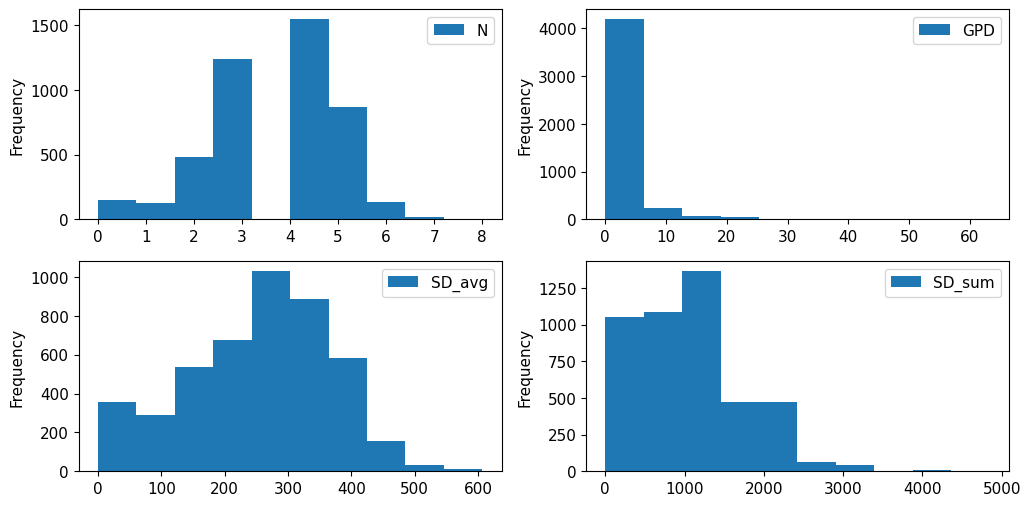

In [614]:
# df_result_final.GPD.plot(kind='hist', bins=40)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
df_result_final.plot(kind='hist', y='N', ax=axs[0,0])
df_result_final.plot(kind='hist', y='GPD', ax=axs[0,1])
df_result_final.plot(kind='hist', y='SD_avg', ax=axs[1,0])
df_result_final.plot(kind='hist', y='SD_sum', ax=axs[1,1])

<AxesSubplot: >

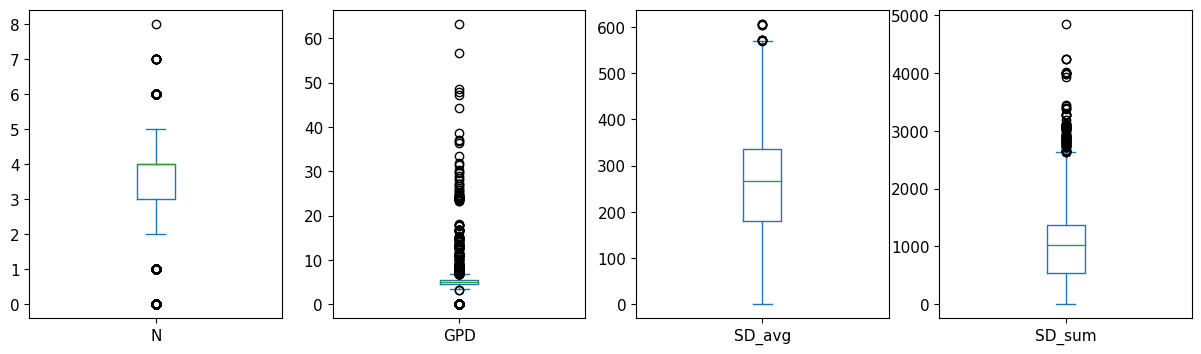

In [616]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
df_result_final.N.plot(kind='box', ax=axs[0])
df_result_final.GPD.plot(kind='box', ax=axs[1])
df_result_final.SD_avg.plot(kind='box', ax=axs[2])
df_result_final.SD_sum.plot(kind='box', ax=axs[3])

## Remove unreasonable records

- `N` >= 6

In [623]:
df_result_final.drop(df_result_final[df_result_final['N'] >= 6].index, inplace=True)
df_result_final.shape

(4416, 6)

<AxesSubplot: >

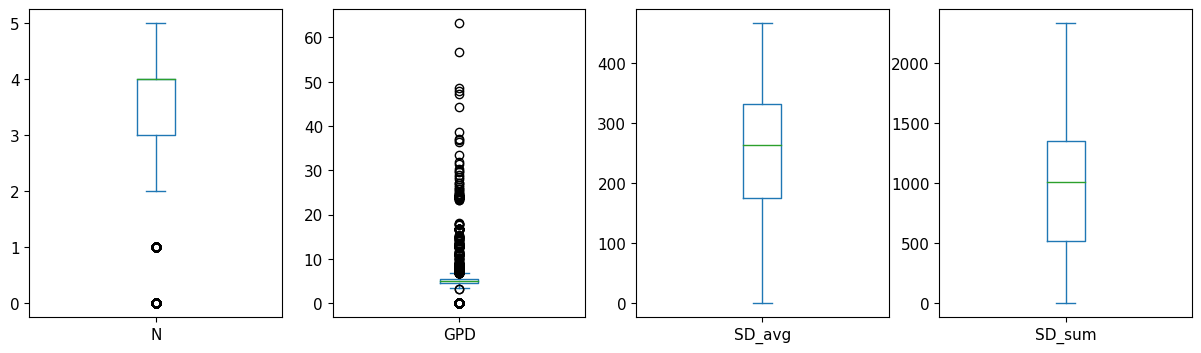

In [624]:
# boxplots again
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,4))
df_result_final.N.plot(kind='box', ax=axs[0])
df_result_final.GPD.plot(kind='box', ax=axs[1])
df_result_final.SD_avg.plot(kind='box', ax=axs[2])
df_result_final.SD_sum.plot(kind='box', ax=axs[3])

## Add delta

In [673]:
df_result_final.iloc[-1, 0]

5.0

In [665]:
len([0] + [df_result_final['N'][i] - df_result_final['N'][i-1] for i in range(1, df_result_final.shape[0])])

4416

In [668]:
nrows = df_result_final.shape[0]
df_result_final['N_delta'] = [0] + [df_result_final['N'][i] - df_result_final['N'][i-1] for i in range(1, nrows)]
df_result_final['GPD_delta'] = [0] + [df_result_final['GPD'][i] - df_result_final['GPD'][i-1] for i in range(1, nrows)]
df_result_final['SD_sum_delta'] = [0] + [df_result_final['SD_sum'][i] - df_result_final['SD_sum'][i-1] for i in range(1, nrows)]
df_result_final['SD_avg_delta'] = [0] + [df_result_final['SD_avg'][i] - df_result_final['SD_avg'][i-1] for i in range(1, nrows)]

df_result_final

N       GPD       SD_sum      SD_avg process_date  \
2023-04-23_20:32:22.592  3.0  3.736265   762.274323  254.091441   2023-04-23   
2023-04-23_20:32:22.761  4.0  3.985814  1201.510086  300.377522   2023-04-23   
2023-04-23_20:32:22.838  4.0  4.002822  1204.838730  301.209682   2023-04-23   
2023-04-23_20:32:22.911  3.0  3.783055   765.529175  255.176392   2023-04-23   
2023-04-23_20:32:22.988  4.0  4.030743  1206.281021  301.570255   2023-04-23   
...                      ...       ...          ...         ...          ...   
2023-04-23_20:56:21.824  4.0  4.509368  1221.717155  305.429289   2023-04-23   
2023-04-23_20:56:22.857  5.0  4.683995  1789.612885  357.922577   2023-04-23   
2023-04-23_20:56:27.044  5.0  4.790808  1787.579865  357.515973   2023-04-23   
2023-04-23_20:56:38.877  5.0  4.440753  1861.328827  372.265765   2023-04-23   
2023-04-23_20:56:39.259  5.0  4.469001  1835.445343  367.089069   2023-04-23   

                            timestamp  N_delta  GPD_delta  SD_sum_delta  \
2023-04-23_20:32:22.592  20:32:22.592      0.0   0.000000      0.000000   
2023-04-23_20:32:22.761  20:32:22.761      1.0   0.249549    439.235764   
2023-04-23_20:32:22.838  20:32:22.838      0.0   0.017008      3.328644   
2023-04-23_20:32:22.911  20:32:22.911     -1.0  -0.219767   -439.309555   
2023-04-23_20:32:22.988  20:32:22.988      1.0   0.247688    440.751846   
...                               ...      ...        ...           ...   
2023-04-23_20:56:21.824  20:56:21.824     -1.0   0.165306   -579.189766   
2023-04-23_20:56:22.857  20:56:22.857      1.0   0.174627    567.895729   
2023-04-23_20:56:27.044  20:56:27.044      0.0   0.106813     -2.033020   
2023-04-23_20:56:38.877  20:56:38.877      0.0  -0.350055     73.748962   
2023-04-23_20:56:39.259  20:56:39.259      0.0   0.028248    -25.883484   

                         SD_avg_delta  
2023-04-23_20:32:22.592      0.000000  
2023-04-23_20:32:22.761     46.286081  
2023-04-23_20:32:22.838      0.832161  
2023-04-23_20:32:22.911    -46.033291  
2023-04-23_20:32:22.988     46.393864  
...                               ...  
2023-04-23_20:56:21.824    -54.752095  
2023-04-23_20:56:22.857     52.493288  
2023-04-23_20:56:27.044     -0.406604  
2023-04-23_20:56:38.877     14.749792  
2023-04-23_20:56:39.259     -5.176697  

[4416 rows x 10 columns]

## Add in timestamp

In [625]:
# create timestamp column from index
df_result_final[['process_date', 'timestamp']] = df_result_final.index.to_frame()[0].str.split('_', expand=True)
df_result_final.head()

N       GPD       SD_sum      SD_avg process_date  \
2023-04-23_20:32:22.592  3.0  3.736265   762.274323  254.091441   2023-04-23   
2023-04-23_20:32:22.761  4.0  3.985814  1201.510086  300.377522   2023-04-23   
2023-04-23_20:32:22.838  4.0  4.002822  1204.838730  301.209682   2023-04-23   
2023-04-23_20:32:22.911  3.0  3.783055   765.529175  255.176392   2023-04-23   
2023-04-23_20:32:22.988  4.0  4.030743  1206.281021  301.570255   2023-04-23   

                            timestamp  
2023-04-23_20:32:22.592  20:32:22.592  
2023-04-23_20:32:22.761  20:32:22.761  
2023-04-23_20:32:22.838  20:32:22.838  
2023-04-23_20:32:22.911  20:32:22.911  
2023-04-23_20:32:22.988  20:32:22.988

In [626]:
df_result_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4416 entries, 2023-04-23_20:32:22.592 to 2023-04-23_20:56:39.259
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   N             4416 non-null   float64
 1   GPD           4416 non-null   float64
 2   SD_sum        4416 non-null   float64
 3   SD_avg        4416 non-null   float64
 4   process_date  4416 non-null   object 
 5   timestamp     4416 non-null   object 
dtypes: float64(4), object(2)
memory usage: 241.5+ KB


# Plot 

In [588]:
%matplotlib inline

In [627]:
print(min(df_result_final.timestamp), max(df_result_final.timestamp))

20:32:22.592 20:56:39.259


<AxesSubplot: xlabel='timestamp'>

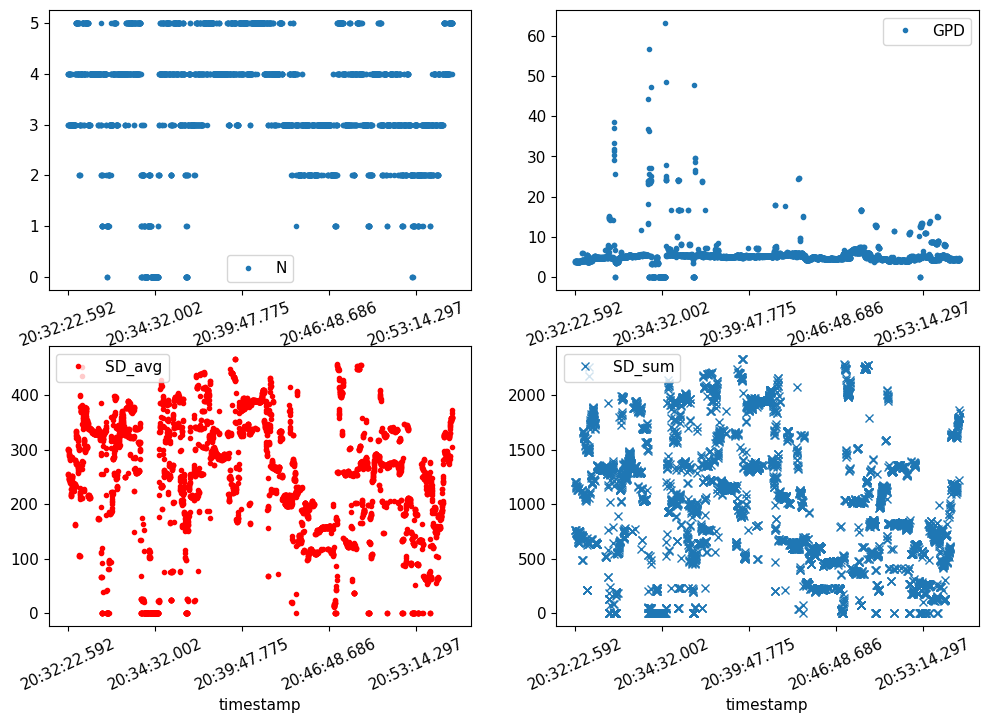

In [632]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
df_result_final.plot(kind='line', x='timestamp', y='N', style='.', use_index=True, rot=20, ax=axs[0,0])
df_result_final.plot(kind='line', x='timestamp', y='GPD', style='.', use_index=True, rot=20, ax=axs[0,1])
df_result_final.plot(kind='line', x='timestamp', y='SD_avg', style='r.', rot=25, ax=axs[1,0])
df_result_final.plot(kind='line', x='timestamp', y='SD_sum', style='x', rot=25, ax=axs[1,1])

<AxesSubplot: xlabel='timestamp'>

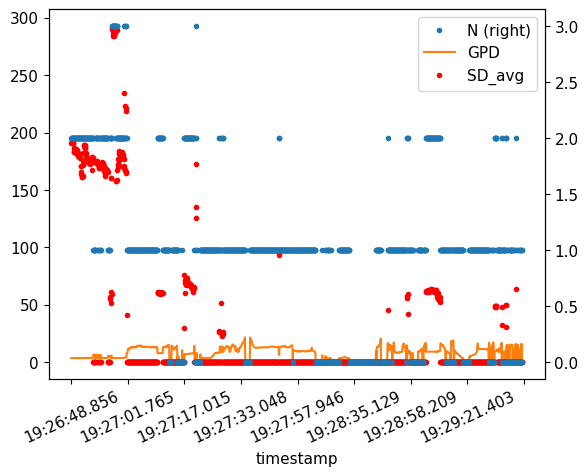

In [540]:
df_result_final.plot(kind='line', 
                     x='timestamp', 
                     y=['N', 'GPD', 'SD_avg'], 
                     style=['.','-','r.'], 
                     rot=25, 
                     secondary_y='N', 
                     mark_right=True)

<AxesSubplot: xlabel='timestamp'>

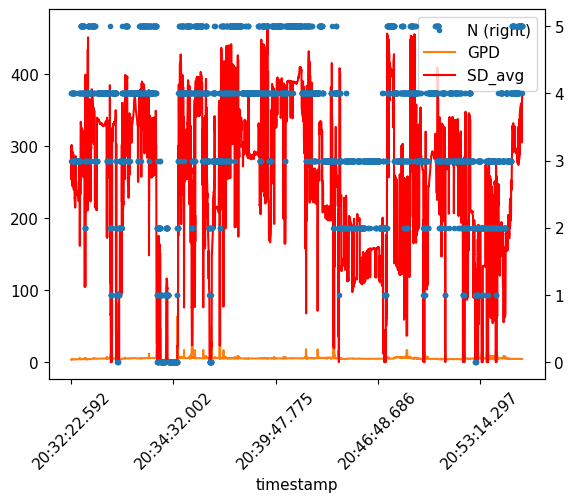

In [637]:
df_result_final.plot(kind='line', 
                     x='timestamp', 
                     y=['N', 'GPD', 'SD_avg'], 
                     style=['.','-','r-'], 
                     rot=45, 
                     secondary_y='N', 
                     mark_right=True)

# Put to streamlit

In [216]:
import streamlit as st

In [231]:
st.set_page_config(page_title='Real-time group dynamics dashboard v0.1'
                  ,page_icon='tick'
                  ,layout='wide'
                  )

st.title('Real-time group dynamics dashboard')

placeholder = st.empty()

while True:
    
    N = df_result_final.iloc[-1,0]
    GPD = df_result_final.iloc[-1,1]
    SD_sum = df_result_final.iloc[-1,2]
    SD_avg = df_result_final.iloc[-1,3]
    
    with placeholder.container():

        st.markdown('## Current KPIs x4')
        kpi1,kpi2,kpi3,kpi4 = st.columns(4)

        kpi1.metric(label="Number of people", value=N)
        kpi2.metric(label="GPD", value=GPD)
        kpi3.metric(label="Total social distance", value=SD_sum_current)
        kpi4.metric(label='Current average distance', value=SD_avg_current)

        st.markdown('## Overall KPIs x2')
        kpi5,kpi6 = st.columns(2)
        kpi5.metric(label='Average Total Distance', value=SD_sum_avg)
        kpi6.metric(label="Average Distance", value=SD_avg_avg)

        st.markdown('## Detail measurements')
        col7,col8 = st.columns(2)
        col7.dataframe(df_result_final, use_container_width=False)
        col8.image(resized, use_column_width=True, channels='RGB', caption='Group dynamics')

        st.dataframe(df_result_person, use_container_width=True)



        time.sleep(1)


In [638]:
st.image(result.ims[0])

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [640]:
placeholder.empty()

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [ ]:
# run locally
# cap = cv2.VideoCapture('rtsp://10.233.126.203:9000/live')
# cap = cv2.VideoCapture('../../../recordings/lego_rover_build_44mins/split/split000.mp4')
# cap = cv2.VideoCapture('../../../recordings/lego_rover_build_44mins/split2/split005.mp4')
# cap = cv2.VideoCapture('../../../recordings/lego_rover_build_44mins/split2/split008.mp4')
# cap = cv2.VideoCapture('../../../recordings/lego_rover_build_44mins/split2/split010.mp4')
# cap = cv2.VideoCapture('../../../recordings/lego_rover_build_44mins/split2/split015.mp4')
cap = cv2.VideoCapture(r'C:\Users\EricWang\Videos\WIN_20221202_12_28_17_Pro.mp4')
# cap = cv2.VideoCapture(r'G:\My Drive\U\phd\work4_openvino\PycharmProjects\projectCV\dashboard\data\WIN_20221202_12_28_17_Pro.mp4')

# run in google colab
# cap = cv2.VideoCapture('/content/drive/MyDrive/U/phd/work4_openvino/recordings/lego_rover_build_44mins/split10s/split001.mp4')

while cap.isOpened():
    success, frame = cap.read()
    h, w, _ = frame.shape
    size = (w, h)
    print(size)
    break

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
        
    # recolor
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # make image writable to False to improve prediction performance
    image.flags.writeable = False
#     result = yolo_model(image)
    # recolor image back to BGR for rendering
    image.flags.writeable = True
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    print(result.xyxy)
    
    cv2.imshow('Image', image)
#     print('aaaa')

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Add landmark calculation

In [ ]:
# webcam
# cap = cv2.VideoCapture(0)

# run locally
# save video file as output.avi
# out = cv2.VideoWriter('output/output_2min.avi', cv2.VideoWriter_fourcc(*"MJPG"), 20, size)

# run in google colab
# save video file as output.avi
# out = cv2.VideoWriter('/content/drive/MyDrive/U/phd/work4_openvino/PycharmProjects/projectCV/HumanPoseEstimation/output/output5.avi',
#                      cv2.VideoWriter_fourcc(*"MJPG"), 20, size)

# out = cv2.VideoWriter('output/output5.avi', cv2.VideoWriter_fourcc(*"MJPG"), 20, size)


count_r = 0
count_l = 0
pTime = 0
dir_r = 0
dir_l = 0
frames = []
arm_count = {}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # recolor
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # make image writable to False to improve prediction performance
    image.flags.writeable = False

    result = yolo_model(image)

    # recolor image back to BGR for rendering
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    print(result.xyxy)

    img_list = []
    MARGIN = 15

    for idx, (xmin, ymin, xmax, ymax, confidence, clas) in enumerate(result.xyxy[0].tolist()):
        if idx == 0:
            pstart = 300
            pend = 400
        elif idx == 1:
            pstart = 450
            pend = 550
        elif idx == 2:
            pstart = 600
            pend = 700
        else:
            pstart = 0
            pend = 0

        with mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
            # pose prediction
            image_crop = image[int(ymin) + MARGIN:int(ymax) + MARGIN, int(xmin) + MARGIN:int(xmax) + MARGIN:]
            results = pose.process(image_crop)

            # draw landmarks
            mp_drawing.draw_landmarks(
                image[int(ymin) + MARGIN:int(ymax) + MARGIN, int(xmin) + MARGIN:int(xmax) + MARGIN:],
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                )

            # img = findpose(img, draw=False)
            lmList = findposition(results, image_crop, draw=False)

            if len(lmList) != 0:
                # right arm
                angle_r = findAngle(lmList, image_crop, 12, 14, 16, True)
                # convert to percentage - check the tradeoff between range and accuracy
                # this is also a place to filter out noise poses
                per_r = np.interp(angle_r, (30, 180), (0, 100))  # from () to ()
                # bar_r = np.interp(angle_r, (30, 170), (300, 400)) # use angle
                # bar_r = np.interp(per_r, (40, 100), (300, 400))  # use percentage
                bar_r = np.interp(per_r, (30, 100), (pstart, pend))  # use percentage
                print('angle_right_arm {}, percentage {}'.format(angle_r, per_r))

                # left arm
                angle_l = findAngle(lmList, image_crop, 11, 13, 15, True)
                # convert to percentage - check tradeoff
                per_l = np.interp(angle_l, (30, 180), (0, 100))  # from () to ()
                # bar_l = np.interp(angle_l, (30, 170), (300, 400)) # use angle
                # bar_l = np.interp(per_l, (40, 100), (300, 400))  # use percentage
                bar_l = np.interp(per_l, (30, 100), (pstart, pend))
                print('angle_left_arm {}, percentage {}'.format(angle_l, per_l))

                # TODO: replicate same checks as right arm
                color = (255, 0, 0)  # blue

                # right arm
                if per_r >= 90:
                    color = (0, 255, 0)  # green
                    if dir_r == 0:
                        count_r += 0.5
                        dir_r = 1
                if per_r <= 30:
                    color = (255, 0, 0)  # blue
                    if dir_r == 1:
                        count_r += 0.5
                        dir_r = 0

                # left arm
                if per_l >= 90:
                    color = (0, 255, 0)  # green
                    if dir_l == 0:
                        count_l += 0.5
                        dir_l = 1
                if per_l <= 30:
                    color = (255, 0, 0)  # blue
                    if dir_l == 1:
                        count_l += 0.5
                        dir_l = 0

                print(count_l, count_r)
                count = {'L': count_l, 'R': count_r}
                arm_count.update({idx: {'count': count}})

                # use average percentage as bar value
                bar_avg = np.mean((bar_l, bar_r))

                # count_l_total = int(np.sum([arm_count[i]['count']['L'] for i in range(0, len(arm_count))]))
                # count_r_total = int(np.sum([arm_count[i]['count']['R'] for i in range(0, len(arm_count))]))

                # display arm counts
                # cv2.rectangle(image, (300, 25), (400, 50), color, 2)
                # cv2.rectangle(image, (300, 25), (int(bar_avg), 50), color, cv2.FILLED)
                # cv2.putText(image, 'L {} R {}'.format(count_l, count_r), (50, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)

                # cv2.rectangle(image, (pstart, 25), (pend, 50), color, 2)
                cv2.rectangle(image, (pstart, 25), (pend, 50), color, 2)
                cv2.rectangle(image, (pstart, 25), (int(bar_avg), 50), color, cv2.FILLED)
                # cv2.putText(image, 'L {} R {}'.format(count_l, count_r), (50, 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
                if idx != 0 and idx != 3:
                    count_l_total = int(np.mean([list(arm_count.values())[i]['count']['L'] for i in range(0, len(arm_count))]))
                    # count_r_total = int(np.mean([arm_count[i]['count']['R'] for i in range(0, len(arm_count))]))
                    count_r_total = int(np.mean([list(arm_count.values())[i]['count']['R'] for i in range(0, len(arm_count))]))
                    cv2.putText(image, f"Arms reaching out L {count_l_total} R {count_r_total}", (25, 50),
                                cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)

        # display fps
        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        # cv2.putText(image, 'FPS {}'.format(str(int(fps))), (50, 100), cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)

        img_list.append(image[int(ymin):int(ymax), int(xmin):int(xmax):])

        # cv2.imshow('Image', image)

        # write to video file
        # out.write(image)

    # out.write(image)

    cv2.imshow('Image', image)
    print('aaaa')

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
# out.release()
cv2.destroyAllWindows()

In [ ]:
import streamlit as st

# End